#Predicting Fetal Health Classification:

> In this work, we use machine learning for the prediction of fetal health to prevent child and maternal mortality.



Cardiotocography (CTG) is used during pregnancy to monitor fetal heart rate and uterine contractions. It is monitor fetal well-being and allows early detection of fetal distress. 

 CTG interpretation helps in determining if the pregnancy is high or low risk.  An abnormal CTG may indicate the need for further investigations and potential intervention.
 
# **<span style="color:#F7B2B0;">TABLE OF CONTENTS</span>**

**IMPORTING LIBRARIES**

**LOADING DATA**

**DATA PREPROCESSING**

**DATA ANALYSIS**

**MODEL BUILDING**

**CONCLUSIONS**

 # **<span style="color:#F7B2B0;">IMPORTING LIBRARIES</span>**

**On This Dataset**
**Cardiotocograms (CTGs)** are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.

This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by expert obstetrician into 3 classes:

1. Normal
1. Suspect
1. Pathological

**Features**

* **'baseline value'** FHR baseline (beats per minute)
* **'accelerations'** Number of accelerations per second
* **'fetal_movement'** Number of fetal movements per second
* **'uterine_contractions'** Number of uterine contractions per second
* **'light_decelerations'** Number of light decelerations per second
* **'severe_decelerations'** Number of severe decelerations per second
* **'prolongued_decelerations'** Number of prolonged decelerations per second
* **'abnormal_short_term_variability'** Percentage of time with abnormal short term variability
* **'mean_value_of_short_term_variability'** Mean value of short term variability
* **'percentage_of_time_with_abnormal_long_term_variability'** Percentage of time with abnormal long term variability
* **'mean_value_of_long_term_variability'** Mean value of long term variability 
* **'histogram_width'** Width of FHR histogram
* **'histogram_min' Minimum** (low frequency) of FHR histogram
* **'histogram_max' Maximum** (high frequency) of FHR histogram
* **'histogram_number_of_peaks'** Number of histogram peaks
* **'histogram_number_of_zeroes'** Number of histogram zeros
* **'histogram_mode'** Histogram mode
* **'histogram_mean'** Histogram mean
* **'histogram_median'** Histogram median
* **'histogram_variance'** Histogram variance
* **'histogram_tendency'** Histogram tendency

* **Target**
* **'fetal_health'** Tagged as 1 (Normal), 2 (Suspect) and 3 (Pathological)

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.functions import col
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext

In [2]:
spark_conf = SparkConf().setAppName("Fetal Health").setMaster("local[*]")

# 配置Spark参数
spark_conf.set("spark.executor.memory", "8g")
spark_conf.set("spark.driver.memory", "4g")
spark_conf.set("spark.executor.cores", "6")
spark_conf.set("spark.default.parallelism", "6")

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/25 21:44:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/25 21:45:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
sqlcontext = SQLContext(spark)

path = "./content/fetal_health.csv"


data = sqlcontext.read.format('com.databricks.spark.csv') \
    .options(header='true', inferschema='true', nullValue='NA') \
    .load(path)

# 将DataFrame注册为临时视图，方便后续SQL操作
data.createOrReplaceTempView("data")

data.show(5)

# data = data.withColumn("fetal_health", col("fetal_health").cast("int"))

# data = data.withColumn("fetal_health", when(col("fetal_health") == 1, 0)
#                                .when(col("fetal_health") == 2, 1)
#                                .when(col("fetal_health") == 3, 2))

# data.select("fetal_health").distinct().show()


+--------------+-------------+--------------+--------------------+-------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+---------------+-------------+-------------+-------------------------+--------------------------+--------------+--------------+----------------+------------------+------------------+------------+
|baseline value|accelerations|fetal_movement|uterine_contractions|light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|histogram_width|histogram_min|histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|histogram_mode|histogram_mean|histogram_median|histogram_variance|histogram_tendency|fetal_health|
+--------------+--------

In [4]:
# 导入所需的列和字符串处理函数
from pyspark.sql.functions import col, when, round, concat_ws, upper

# 使用内置数学函数执行数学运算
data_with_math_operations = data.withColumn("squared_accelerations", col("accelerations") ** 2)

# 使用条件语句进行条件操作，这行代码使用内置的条件语句函数 when 和 otherwise，根据不同的条件值设置 health_status 列的值，将 fetal_health 列的值为1的行标记为 "Normal"，为2的行标记为 "Suspect"，为3的行标记为 "Pathological"，其他行标记为 "Unknown"。
data_with_condition = data.withColumn("health_status",
                                      when(col("fetal_health") == 1, "Normal")
                                      .when(col("fetal_health") == 2, "Suspect")
                                      .when(col("fetal_health") == 3, "Pathological")
                                      .otherwise("Unknown"))

# 使用内置字符串函数进行字符串操作，这行代码使用内置的字符串操作函数 concat_ws 和 upper，将每一列的列名转换为大写，并用逗号和空格连接起来，然后将结果存储在新的列 upper_case_columns 中。
data_with_string_operations = data.withColumn("upper_case_columns", concat_ws(", ", *[upper(col(c)) for c in data.columns]))

# 显示数据集的部分结果
data_with_math_operations.select("accelerations", "squared_accelerations").show(5)
data_with_condition.select("fetal_health", "health_status").show(10)
#这行代码选择了新创建的 upper_case_columns 列的前5行，并将其输出显示，参数 truncate=False 确保不截断列的内容。
data_with_string_operations.select("upper_case_columns").show(5, truncate=False)


+-------------+---------------------+
|accelerations|squared_accelerations|
+-------------+---------------------+
|          0.0|                  0.0|
|        0.006|               3.6E-5|
|        0.003|               9.0E-6|
|        0.003|               9.0E-6|
|        0.007| 4.900000000000000...|
+-------------+---------------------+
only showing top 5 rows

+------------+-------------+
|fetal_health|health_status|
+------------+-------------+
|         2.0|      Suspect|
|         1.0|       Normal|
|         1.0|       Normal|
|         1.0|       Normal|
|         1.0|       Normal|
|         3.0| Pathological|
|         3.0| Pathological|
|         3.0| Pathological|
|         3.0| Pathological|
|         3.0| Pathological|
+------------+-------------+
only showing top 10 rows

+-----------------------------------------------------------------------------------------------------------------------------------+
|upper_case_columns                                                

# Exploratory Data Analysis (EDA) and Analysis
In this step we want to get basic information about the data types, columns, null value counts, memory usage, etc. EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

In [5]:
data.show(5)

+--------------+-------------+--------------+--------------------+-------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+---------------+-------------+-------------+-------------------------+--------------------------+--------------+--------------+----------------+------------------+------------------+------------+
|baseline value|accelerations|fetal_movement|uterine_contractions|light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|histogram_width|histogram_min|histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|histogram_mode|histogram_mean|histogram_median|histogram_variance|histogram_tendency|fetal_health|
+--------------+--------

# **<span style="color:#F7B2B0;">DATA ANALYSIS</span>**

**The analysis consist of:**
* Count Plot
* Corelation Heat Map
* Implot
* Swarm And Boxen Plot


In [6]:
from pyspark.sql.functions import col, corr
from scipy import stats
import seaborn as sns

In [7]:
data_pd = data.toPandas()

In [8]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [9]:
data_pd.head()

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  ...  histogram_min  \
0                                               43.0       ...           62.0   
1                                                0.0       ...           68.0   
2                                                0.0       ...           68.0   
3                                                0.0       ...           53.0   
4                                                0.0       ...           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  fetal_health  
0                 1.0           2.0  
1                 0.0           1.0  
2                 0.0           1.0  
3                 1.0           1.0  
4                 1.0           1.0  

[5 rows x 22 columns]

In [10]:
print(f"Dataset Columns:\n{data_pd.columns}")

Dataset Columns:
Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


In [11]:
# Analyse statically insight of data。这部分代码进行了对数据的描述性统计分析，计算了数据中每列的统计摘要信息
#Count tells us the number of NoN-empty rows in a feature. As we can see there are no NoN-empty rows.
#Mean tells us the mean value of that feature.
#Std tells us the Standard Deviation Value of that feature.
#Min tells us the minimum value of that feature.
#25%, 50%, and 75% are the percentile/quartile of each features. This quartile information helps us to detect Outliers.
#Max tells us the maximum value of that feature.

data_pd.describe().T

count        mean  \
baseline value                                      2126.0  133.303857   
accelerations                                       2126.0    0.003178   
fetal_movement                                      2126.0    0.009481   
uterine_contractions                                2126.0    0.004366   
light_decelerations                                 2126.0    0.001889   
severe_decelerations                                2126.0    0.000003   
prolongued_decelerations                            2126.0    0.000159   
abnormal_short_term_variability                     2126.0   46.990122   
mean_value_of_short_term_variability                2126.0    1.332785   
percentage_of_time_with_abnormal_long_term_vari...  2126.0    9.846660   
mean_value_of_long_term_variability                 2126.0    8.187629   
histogram_width                                     2126.0   70.445908   
histogram_min                                       2126.0   93.579492   
histogram_max                                       2126.0  164.025400   
histogram_number_of_peaks                           2126.0    4.068203   
histogram_number_of_zeroes                          2126.0    0.323612   
histogram_mode                                      2126.0  137.452023   
histogram_mean                                      2126.0  134.610536   
histogram_median                                    2126.0  138.090310   
histogram_variance                                  2126.0   18.808090   
histogram_tendency                                  2126.0    0.320320   
fetal_health                                        2126.0    1.304327   

                                                          std    min      25%  \
baseline value                                       9.840844  106.0  126.000   
accelerations                                        0.003866    0.0    0.000   
fetal_movement                                       0.046666    0.0    0.000   
uterine_contractions                                 0.002946    0.0    0.002   
light_decelerations                                  0.002960    0.0    0.000   
severe_decelerations                                 0.000057    0.0    0.000   
prolongued_decelerations                             0.000590    0.0    0.000   
abnormal_short_term_variability                     17.192814   12.0   32.000   
mean_value_of_short_term_variability                 0.883241    0.2    0.700   
percentage_of_time_with_abnormal_long_term_vari...  18.396880    0.0    0.000   
mean_value_of_long_term_variability                  5.628247    0.0    4.600   
histogram_width                                     38.955693    3.0   37.000   
histogram_min                                       29.560212   50.0   67.000   
histogram_max                                       17.944183  122.0  152.000   
histogram_number_of_peaks                            2.949386    0.0    2.000   
histogram_number_of_zeroes                           0.706059    0.0    0.000   
histogram_mode                                      16.381289   60.0  129.000   
histogram_mean                                      15.593596   73.0  125.000   
histogram_median                                    14.466589   77.0  129.000   
histogram_variance                                  28.977636    0.0    2.000   
histogram_tendency                                   0.610829   -1.0    0.000   
fetal_health                                         0.614377    1.0    1.000   

                                                        50%      75%      max  
baseline value                                      133.000  140.000  160.000  
accelerations                                         0.002    0.006    0.019  
fetal_movement                                        0.000    0.003    0.481  
uterine_contractions                                  0.004    0.007    0.015  
light_decelerations                                   0.000    0.003    0.015  
severe

<Axes: xlabel='fetal_health', ylabel='count'>

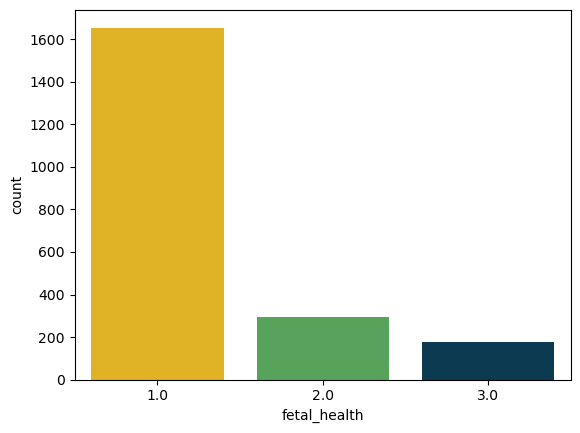

In [12]:
#绘制了一个关于 "fetal_health" 列的计数条形图，用于显示每个类别的样本数量
#first of all let us evaluate the target and find out if our data is imbalanced or not

colours=["#ffc107","#4caf50", "#003f5c"]
sns.countplot(data= data_pd, x="fetal_health",palette=colours)

In [13]:
#Property DataFrame.shape returns a tuple representing the dimensionality of the DataFrame.
print(f"The dataset size: {data_pd.shape}")

The dataset size: (2126, 22)


<Axes: >

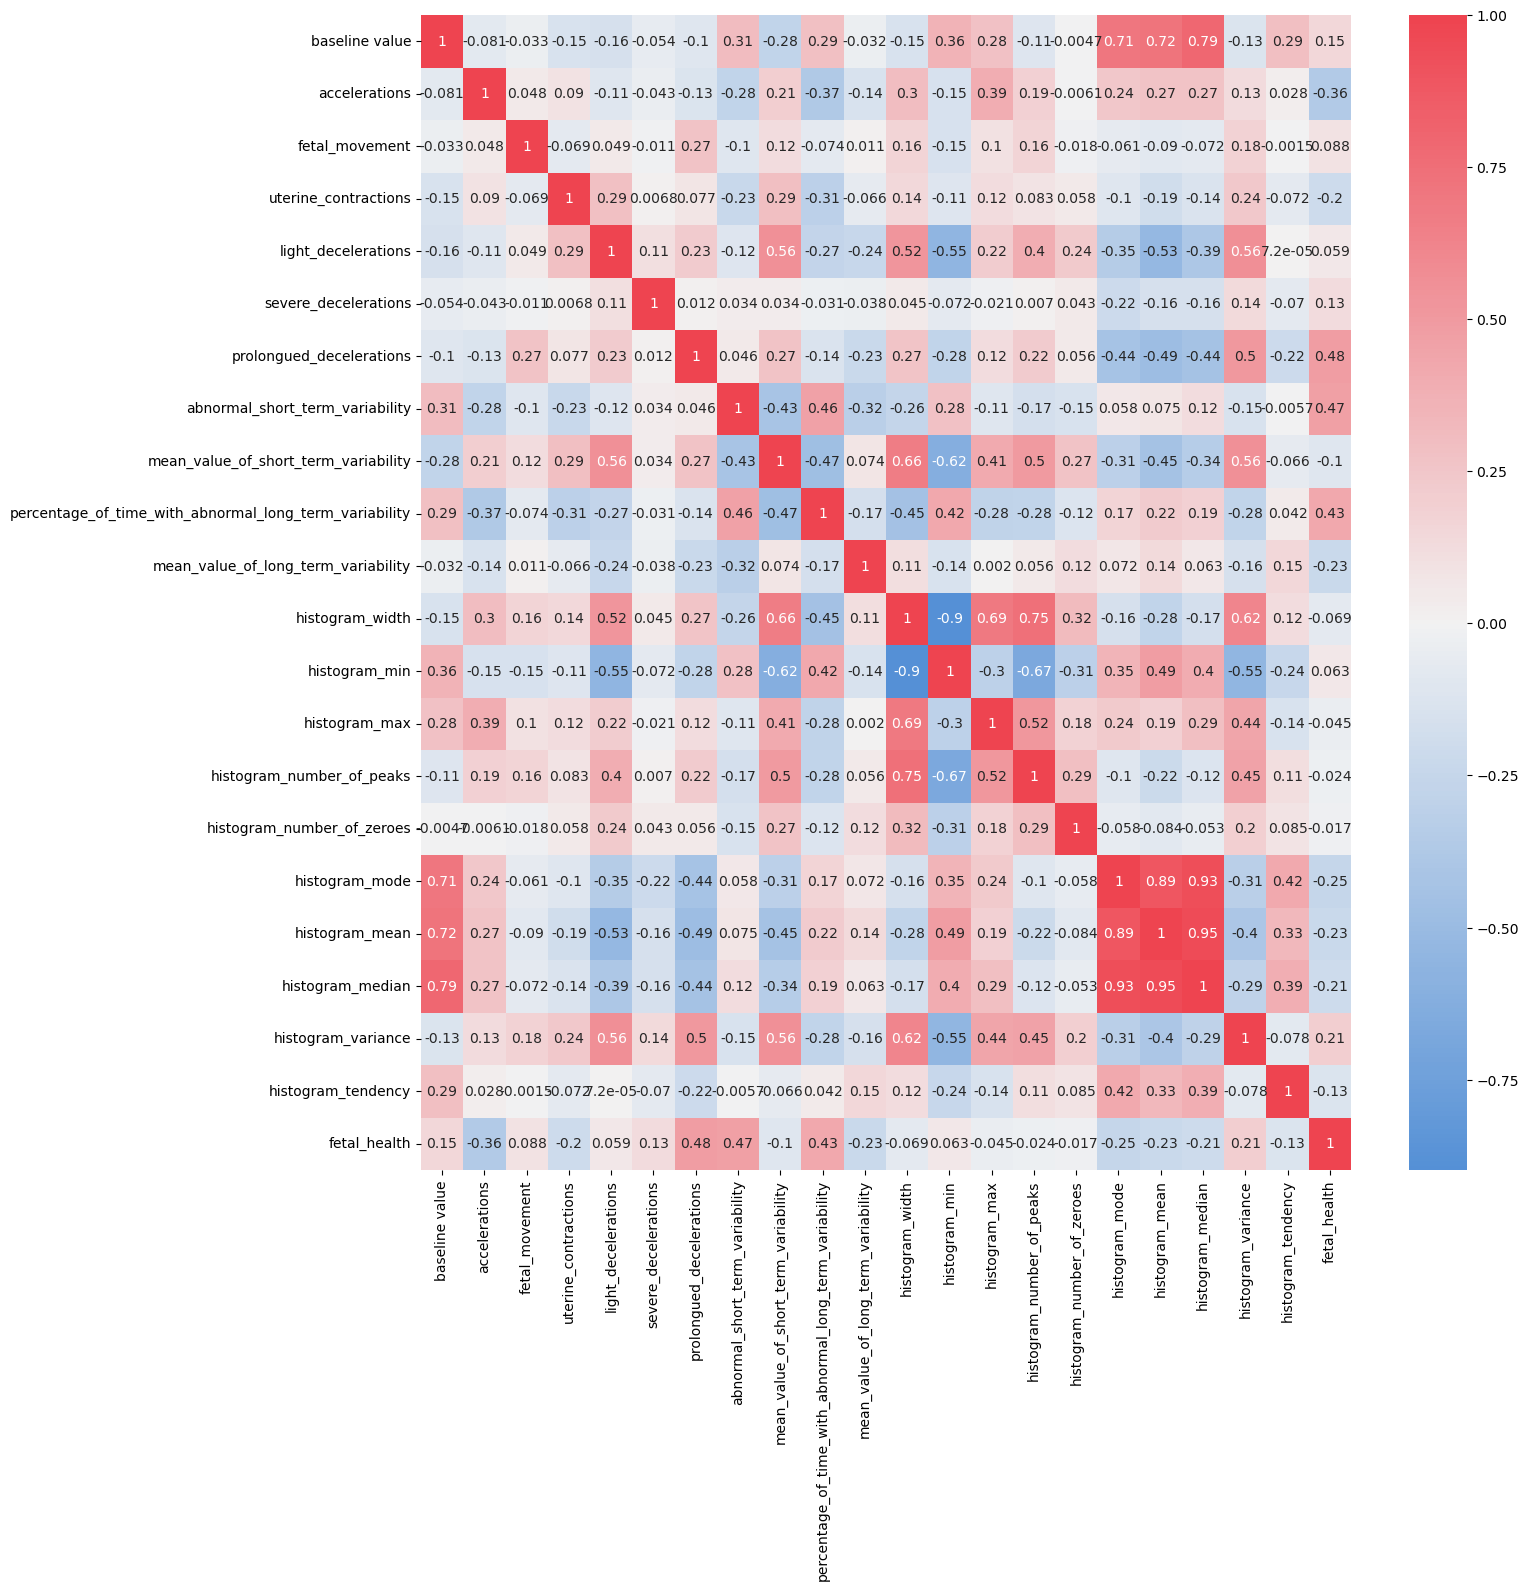

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
#数据集中所有数值特征的相关性矩阵的热力图，使用 sns.heatmap() 函数，其中参数 annot=True 用于在每个单元格显示相关系数
#Based on the correlation matix, it is clear that "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" and "mean_value_of_long_term_variability" are the features with higher correlation with fetal_health. Let's have a closer look at these with fetal_movement on y axis. This will provide a clearer picture of trends that indicate fetus health. 

#correlation matrix
corrmat= data_pd.corr()
plt.figure(figsize=(15,15))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

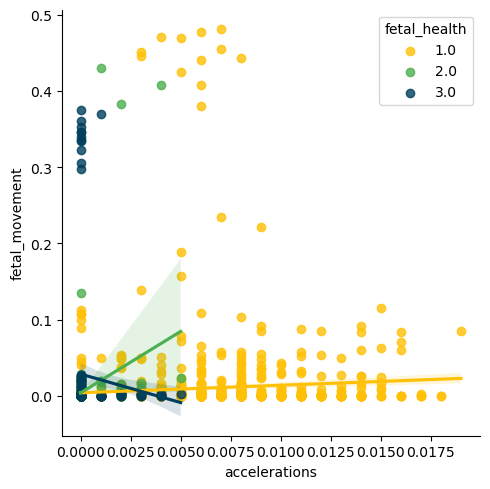

In [15]:
#绘制了一个散点图和线性回归拟合线，其中 x 轴表示 "accelerations" 特征，y 轴表示 "fetal_movement" 特征。通过这个图可以观察到这两个特征之间的线性关系和不同类别的分布情况。
#**Accelerations Vs Fetal Movement by Fetal Health**
sns.lmplot(data =data_pd,x="accelerations",y="fetal_movement",palette=colours, hue="fetal_health",legend_out=False)
plt.show()

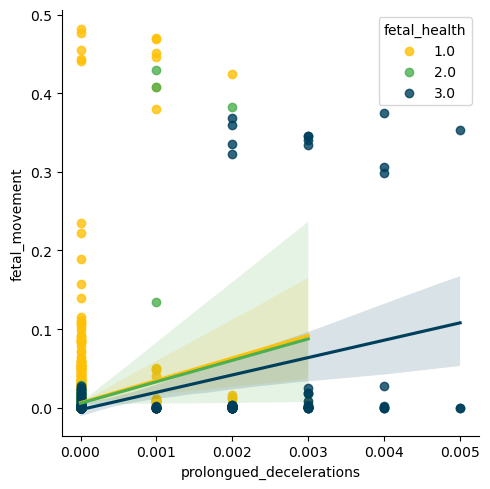

In [16]:
#同样绘制了一个散点图和线性回归拟合线，x 轴为 "prolongued_decelerations" 特征，y 轴为 "fetal_movement" 特征。通过这个图可以观察到这两个特征之间的线性关系和不同类别的分布情况。
#**Prolongued Decelerations Vs Fetal Movement by Fetal Health**
sns.lmplot(data =data_pd,x="prolongued_decelerations",y="fetal_movement",palette=colours, hue="fetal_health",legend_out=False)
plt.show()

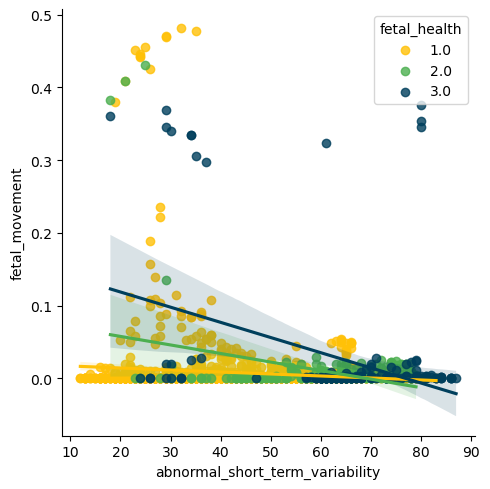

In [17]:
#**Abnormal Short Term Variability Vs Fetal Movement by Fetal Health**
sns.lmplot(data =data_pd,x="abnormal_short_term_variability",y="fetal_movement",palette=colours, hue="fetal_health",legend_out=False)
plt.show()

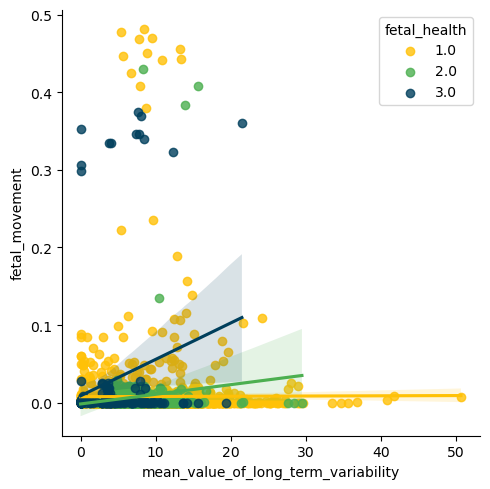

In [18]:
#**Mean Value Of Long Term Variability Vs Fetal Movement by Fetal Health**
sns.lmplot(data =data_pd,x="mean_value_of_long_term_variability",y="fetal_movement",palette=colours, hue="fetal_health",legend_out=False)
plt.show()

In [19]:
#绘制了 swarmplot（散点图）和 boxenplot（增强箱线图）。swarmplot 展示了每个类别中数据点的分布情况，每个点代表一个数据样本。boxenplot 展示了不同类别中数据分布的五数概括和异常值情况。通过这些图表，可以更详细地观察每个特征与目标变量 "fetal_health" 之间的关系。
#We can see the rates of change of the above-mentioned values with each target show a specific trend. 
#We can also spot outliers. Let's have a look at outliers on a more suitable plot.
# columns for detailed visualisation
cols=['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability']

below, I spotted outliers on our dataset. However, it is not quite a good idea to remove them yet as it may lead to overfitting. Though we may end up with better statistics. 

A basic rule of thumb for the outliers in question is:

It is a measurement error or data entry error, correct the error if possible. If you can’t fix it, remove that observation. In our case, this is the outcome of a CTG report so it is unlikely that this was a data entry error. 

If it is not a part of the population you are studying, you can legitimately remove the outlier. In this case, this all is about the fetus, and experts tag the classification. Let's stick with the expert opinion. 

Thus assuming that these are the natural part of the population we are studying, we should not remove it.

In [20]:
#太耗时，平时注释了
# for i in cols:
#     sns.swarmplot(x=data_pd["fetal_health"], y=data_pd[i], color="black", alpha=0.5 )
#     sns.boxenplot(x=data_pd["fetal_health"], y=data_pd[i], palette=colours)
#     plt.show()

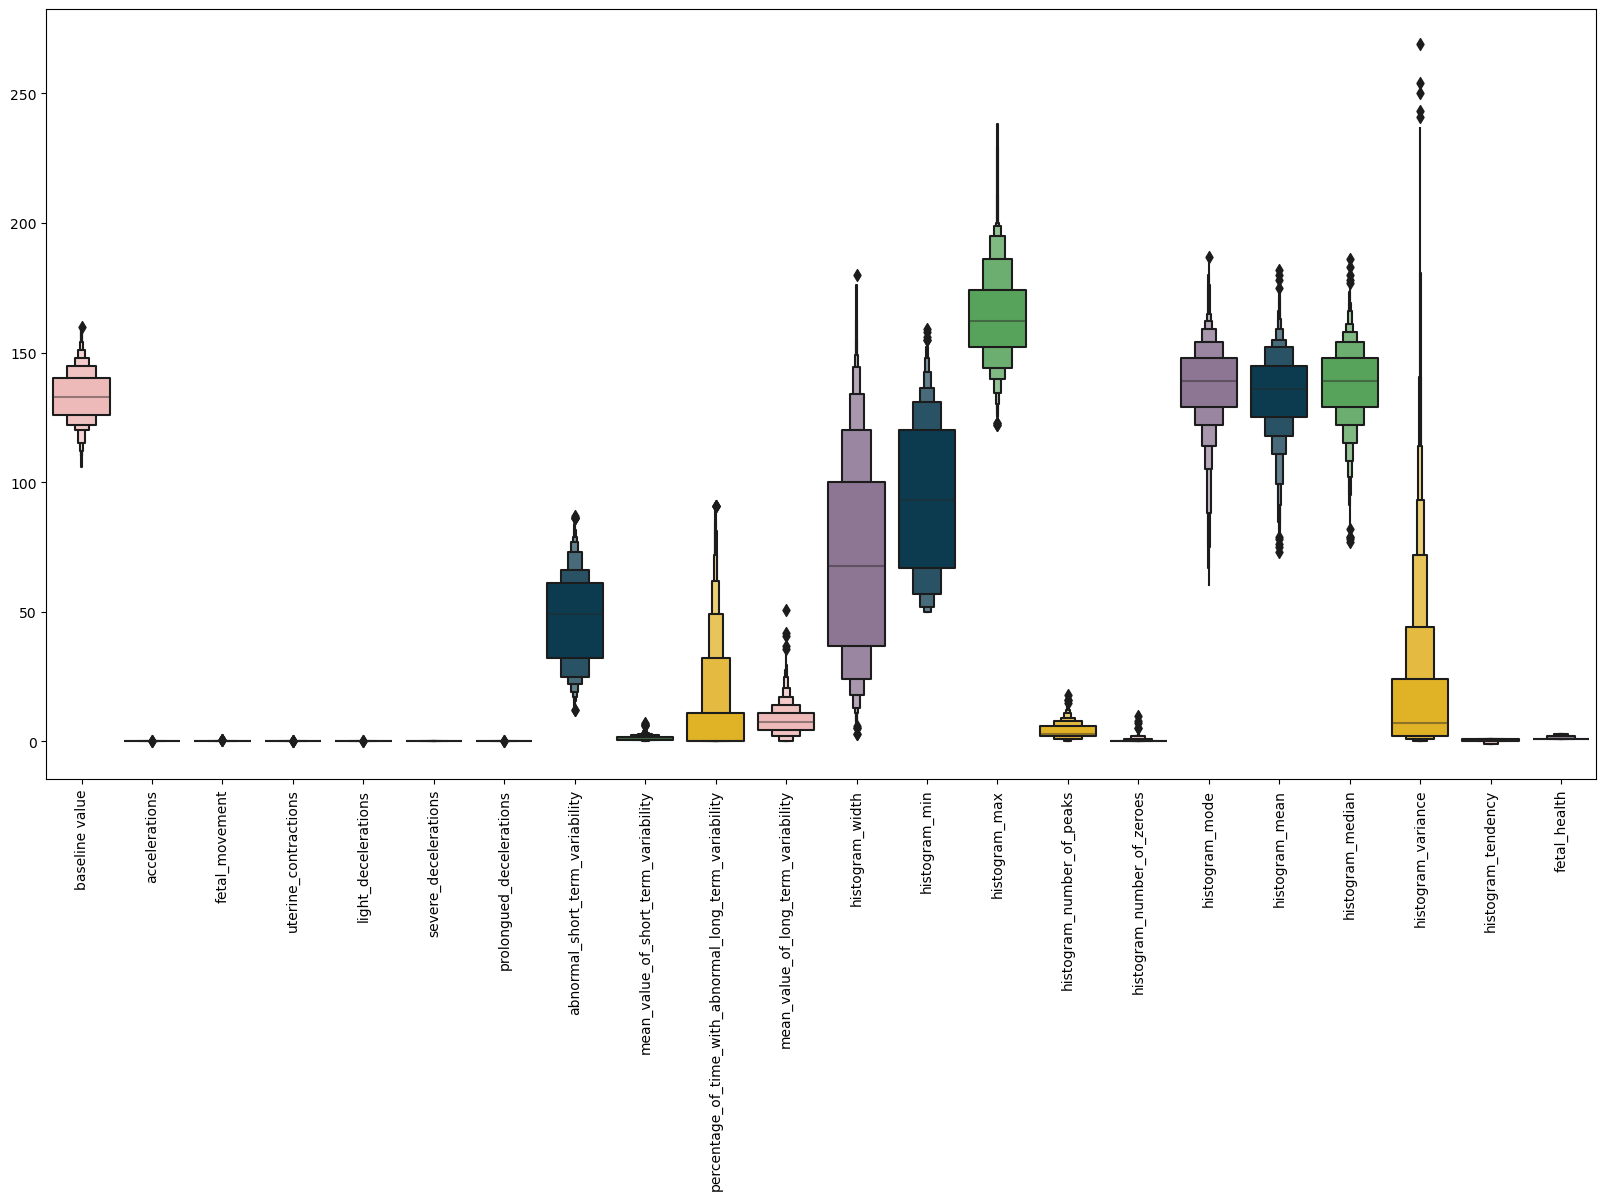

In [21]:
#绘制了一个箱线图，展示了数据集中所有特征的分布情况。每个箱线图的颜色由 shades 列表中的颜色决定，不同类别的箱线图以不同颜色显示。这个图可以帮助观察特征的分布范围、中位数和异常值情况。
#The below plot shows the range of our feature attributes. All the features are in different ranges. To fit this in a model we must scale it to the same range.

#In the model building, we will preprocess the features to do the same.
shades =["#f7b2b0", "#8f7198", "#003f5c", "#4caf50", "#ffc107"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = data_pd,palette = shades)
plt.xticks(rotation=90)
plt.show()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64


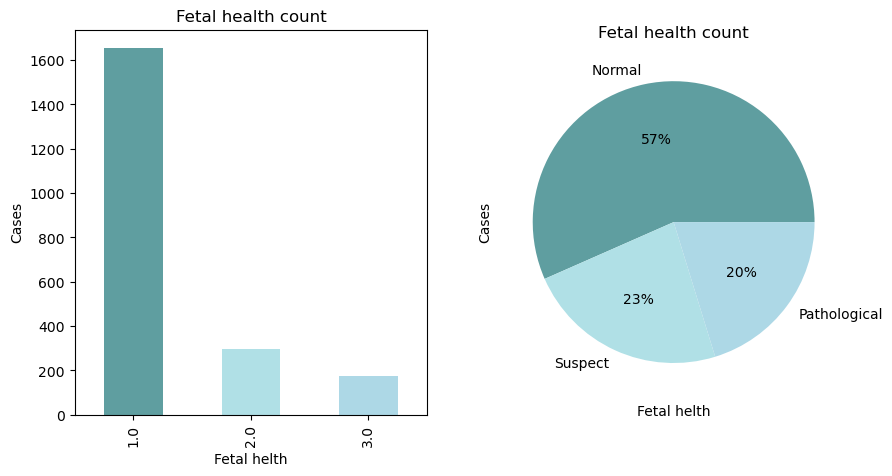

In [22]:
#这部分代码进行了数据的可视化分析。首先，计算了各类别的数量，然后使用 matplotlib 和 seaborn 库绘制了两个子图，一个是 "fetal_health" 列的条形图，另一个是关于 "fetal_health" 列的饼图。这些图形展示了不同健康状态的胎儿在数据集中的分布情况。
#Data visualizations of "fetal_health" column makes easier to understand the fetal state, and visualization also makes it easier to detect patterns of the fetal state (Normal, Suspect, Pathological).
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

total = data_pd["fetal_health"].sum()
normal = total - 471
suspect = total - 1831
pathological = total - 1950

print(data_pd["fetal_health"].value_counts())

plt.figure(figsize = (10,5))
plt.subplot(121)
# sns.countplot(x="fetal_health", data=data)
vis_fetal_health = data_pd.fetal_health.value_counts().plot(figsize=(10, 5), kind="bar", color = ["#5F9EA0", "#B0E0E6", "#ADD8E6"])
plt.title("Fetal health count")
plt.xlabel("Fetal helth")
plt.ylabel("Cases")


plt.subplot(122)
# plt.pie([normal, suspect, pathological], labels=["Normal", "Suspect", "Pathological"], autopct="%1.0f%%")
plt.title("Fetal state") 

vis_pie_fetal_health = plt.pie([normal, suspect, pathological], labels=["Normal", "Suspect", "Pathological"], colors = ["#5F9EA0", "#B0E0E6", "#ADD8E6"], autopct="%1.0f%%")
plt.title("Fetal health count")
plt.xlabel("Fetal helth")
plt.ylabel("Cases")


plt.show()

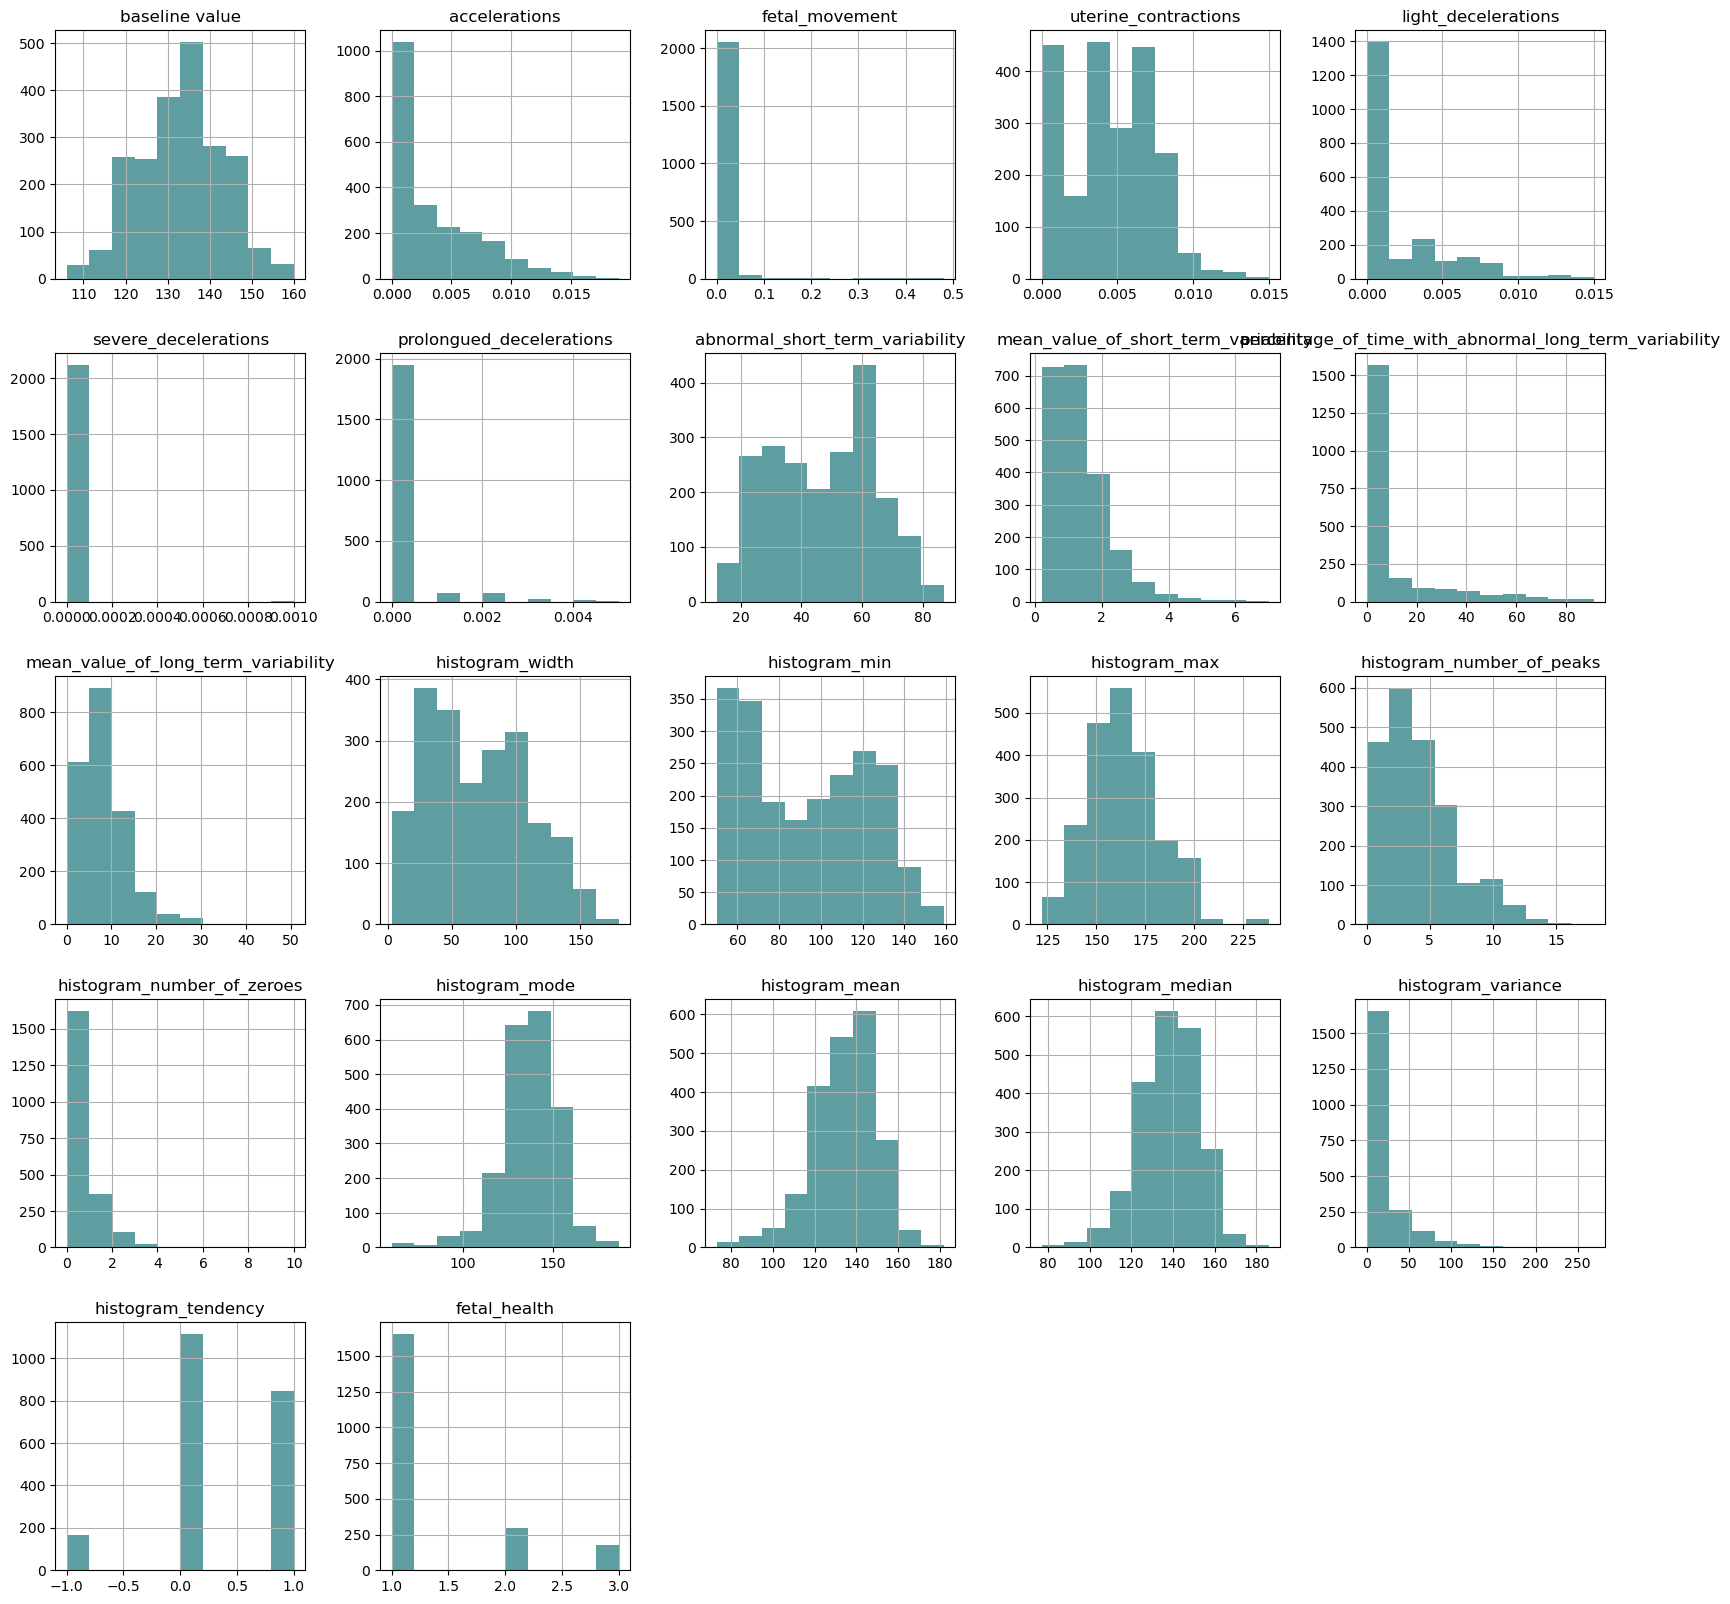

In [23]:
#绘制了数据集中所有数值型特征的直方图
#Data visualizations of "fetal_health" column shows us the percentage of fetal health state.

data_hist_plot = data_pd.hist(figsize = (20,20), color = "#5F9EA0")


The important things we could learn about the above plot is Skewness. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. There are three types of skewed distributions. A right (or positive) skewed distribution, left (or negative) skewed distribution, and normal distribution.
> A left-skewed distribution has a long left tail. Left-skewed distributions are also called negatively-skewed distributions. That’s because there is a long tail in the negative direction on the number line. The mean is also to the left of the peak.

> A right-skewed distribution has a long right tail. Right-skewed distributions are also called positive-skew distributions. That’s because there is a long tail in the positive direction on the number line. The mean is also to the right of the peak.

> The skewness for a normal distribution is zero and looks a bell curve.

In [24]:
# 描述性统计分析，这部分代码进行了数据的描述性统计分析，计算了数据中每列的统计摘要信息（如均值、标准差、最小值、最大值等）。这些统计量可以帮助您了解数据的整体分布和特征。
descriptive_stats = data.describe()
descriptive_stats.show()

23/08/25 21:45:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+------------------+------------------+------------------+-------------------------+--------------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|   baseline value|       accelerations|      fetal_movement|uterine_contractions| light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|   histogram_width|     histogram_min|     histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|    histogram_mode|    histogr

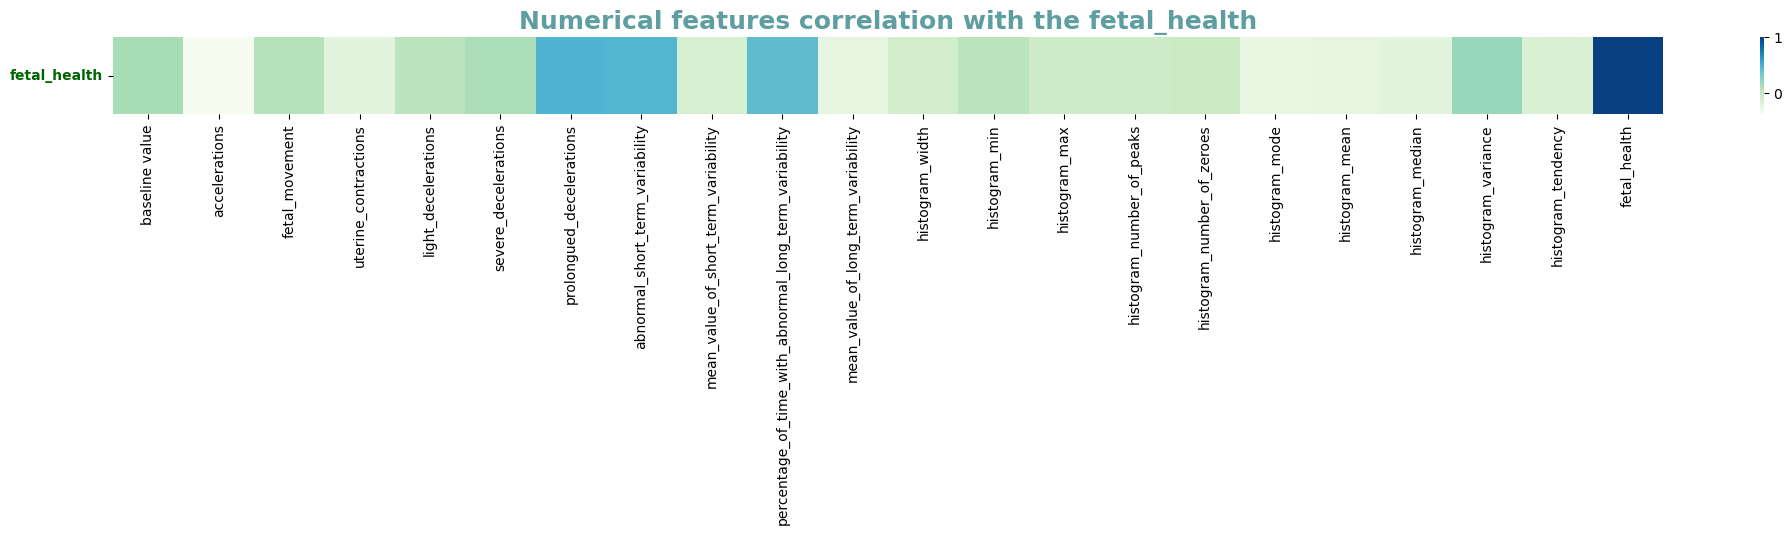

In [25]:
#计算了数值型特征之间的相关性矩阵，并绘制了一个热力图，显示与 "fetal_health" 列相关性最高的数值特征。通过热力图可以直观地看出不同特征之间的相关性。
#Correlation Numeric featurs with output variable(fetal_health)
#Here, we want to show the correlation between numerical features and the target "fetal_health", in order to have a first idea of the connections between features. Just by looking at the heatmap below we can see some features have the dark colors, Those features have high correlation with the target.

numeric_data = data_pd.select_dtypes(exclude="object")
numeric_corr = numeric_data.corr()
f,ax=plt.subplots(figsize=(25,1))
sns.heatmap(numeric_corr.sort_values(by=["fetal_health"], ascending=False).head(1), cmap="GnBu")
plt.title("Numerical features correlation with the fetal_health", weight="bold", fontsize=18, color="#5F9EA0")
plt.yticks(weight="bold", color="darkgreen", rotation=0)

plt.show()

In [26]:
#We can see three features: "prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" have high correlation with the target culumn (fetal_health).
Num_feature = numeric_corr["fetal_health"].sort_values(ascending=False).head(20).to_frame()

cm = sns.light_palette("#5F9EA0", as_cmap=True)

style = Num_feature.style.background_gradient(cmap=cm)
style

# Scatter matrix

> A scatter plot matrix is a grid (or matrix) of scatter plots used to visualize bivariate relationships between combinations of variables. Each scatter plot in the matrix visualizes the relationship between a pair of variables, allowing many relationships to be explored in one chart.

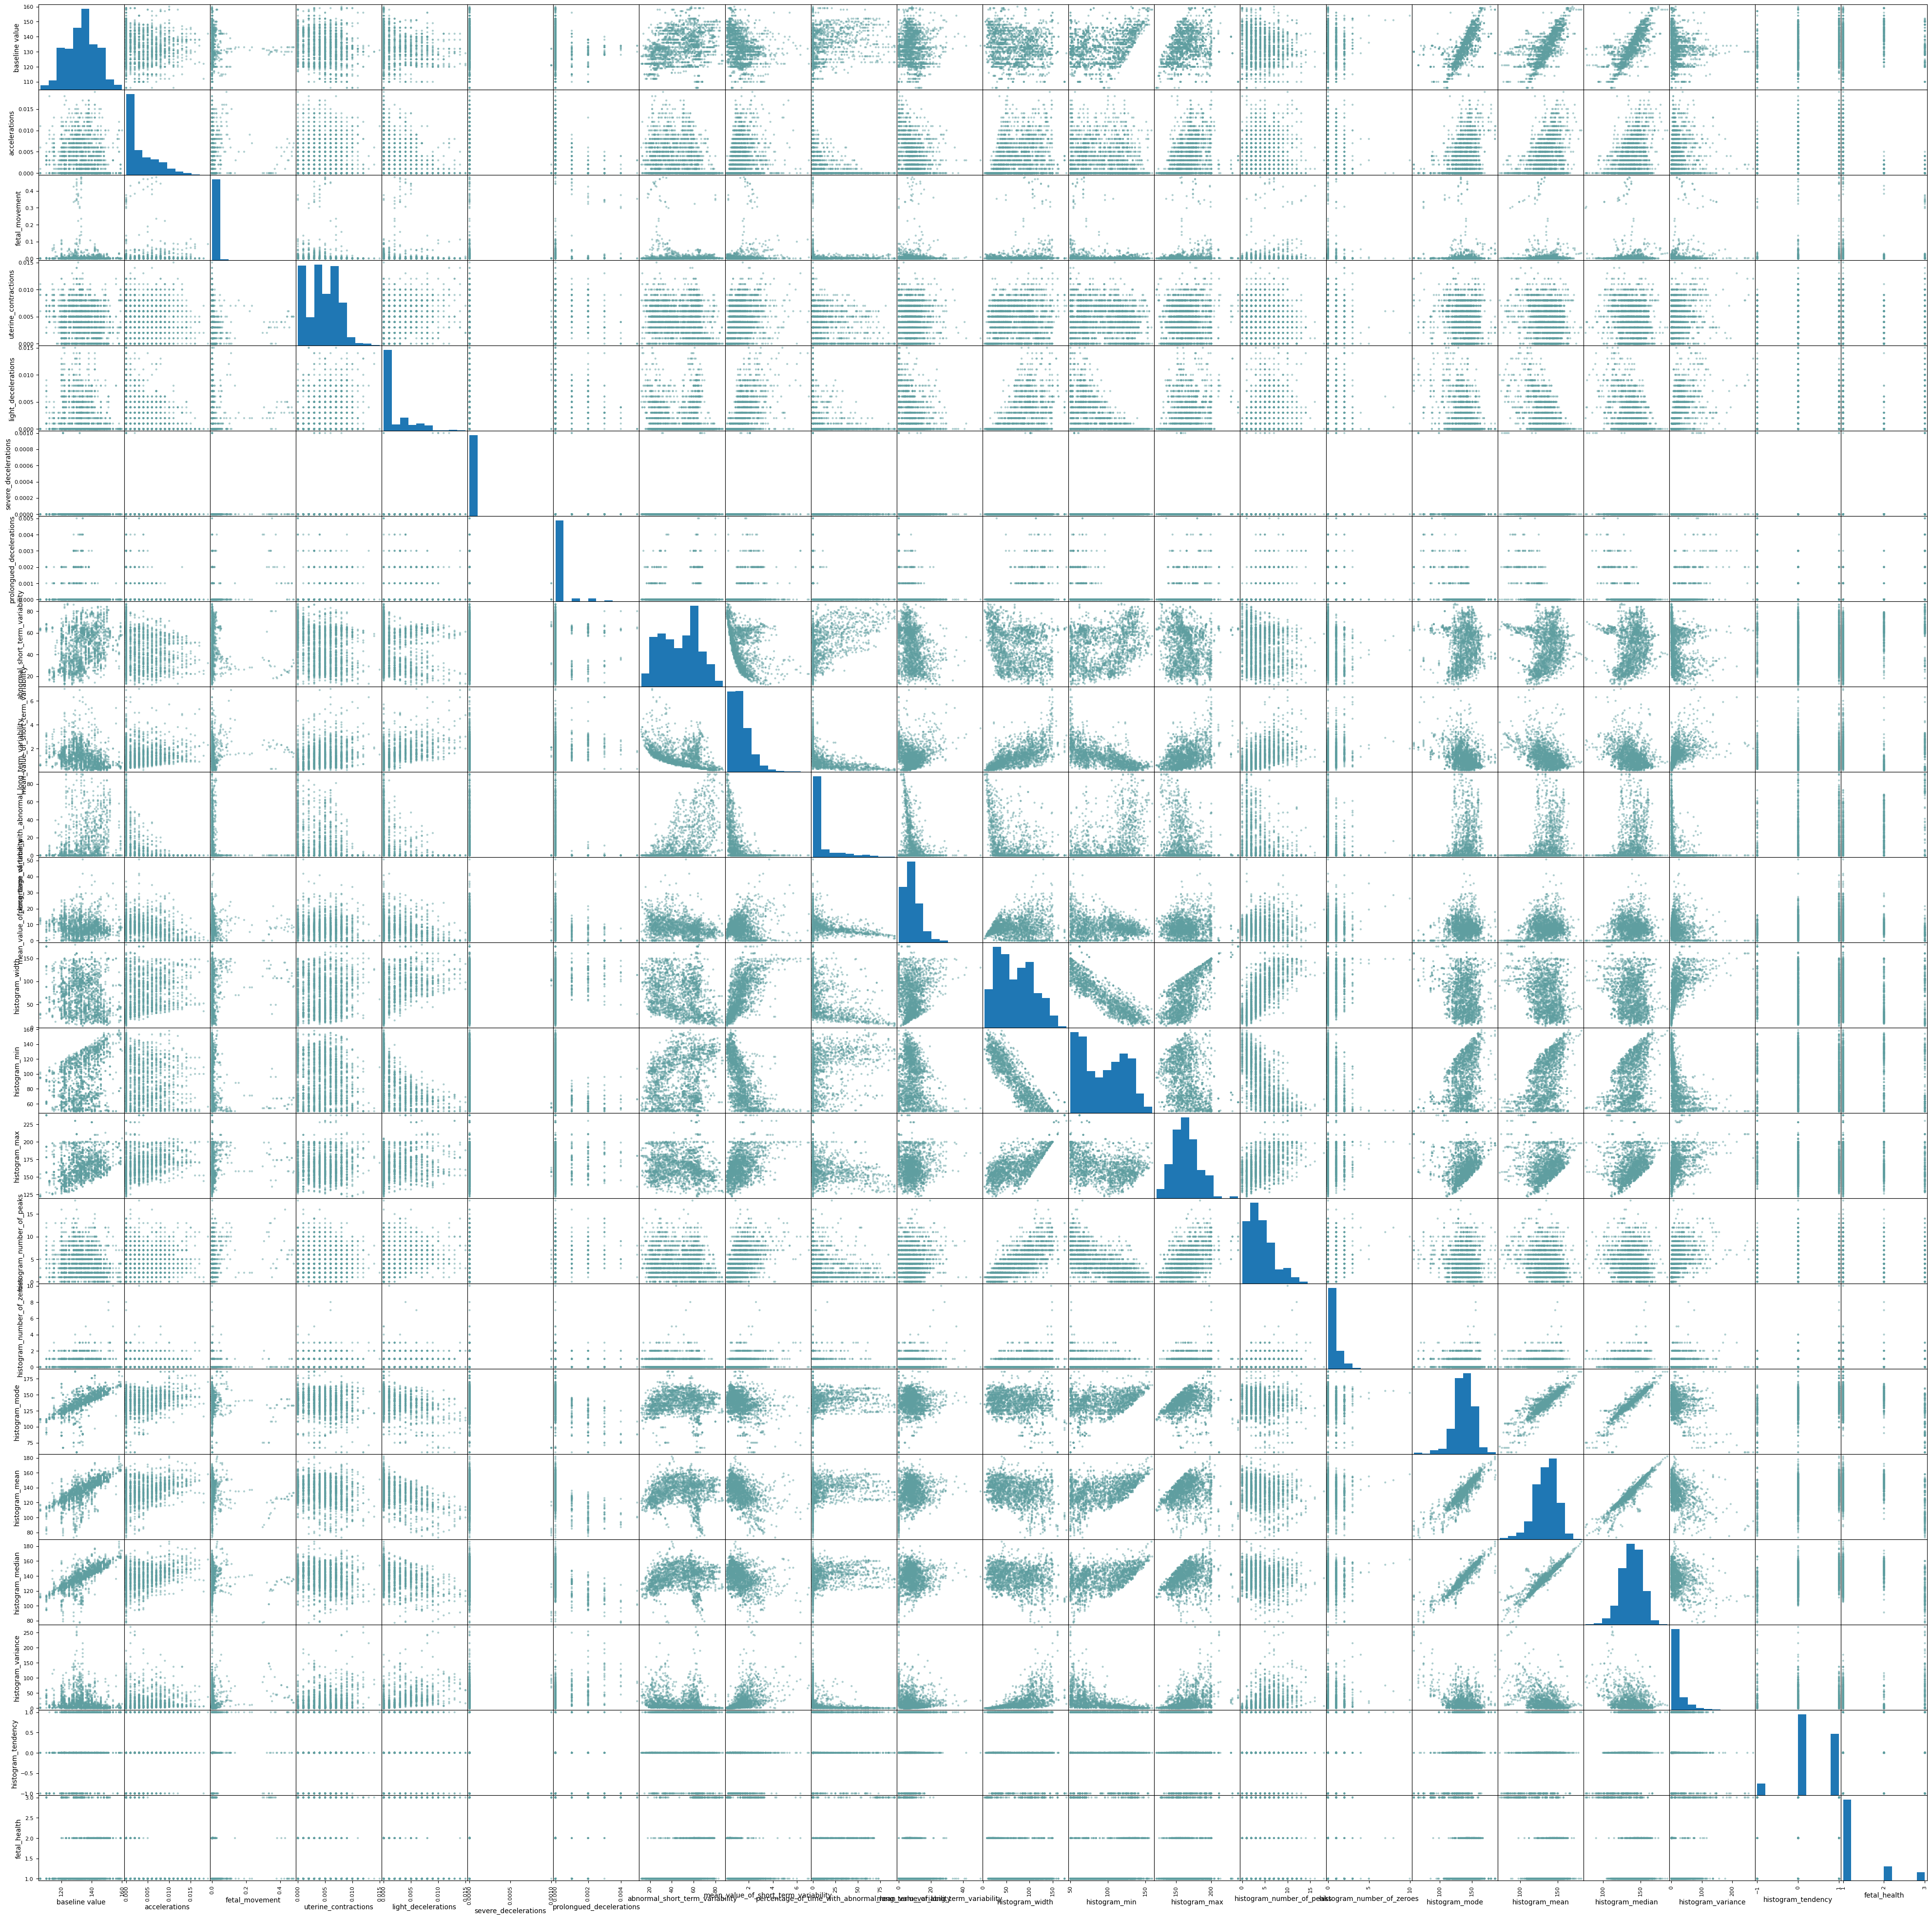

In [27]:
#绘制了一个散点矩阵图，展示了数据集中各个数值特征两两之间的散点图关系。散点矩阵图可以用于探索特征之间的关系，例如线性相关性或聚类情况。
from pandas.plotting import scatter_matrix
scatterMatrix = scatter_matrix(data_pd,figsize=(50, 50), color = "#5F9EA0")


In [28]:
#这部分代码计算了 "fetal_health" 列的描述性统计信息，包括均值、标准差、最小值、最大值等。
data_pd["fetal_health"].describe()


count    2126.000000
mean        1.304327
std         0.614377
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: fetal_health, dtype: float64

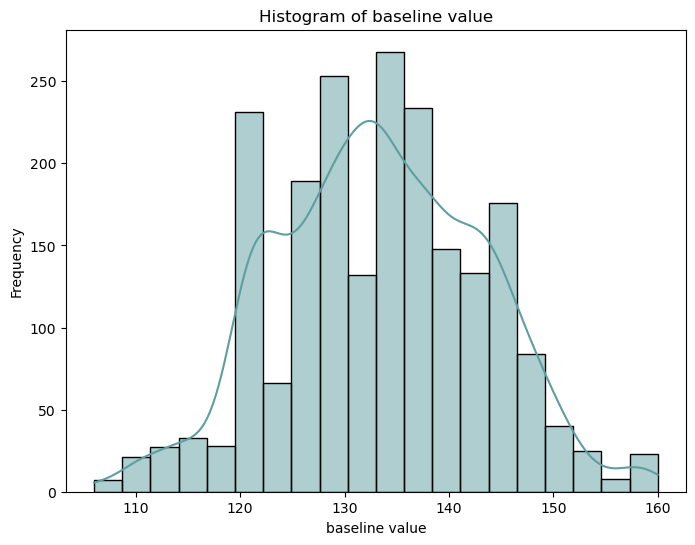

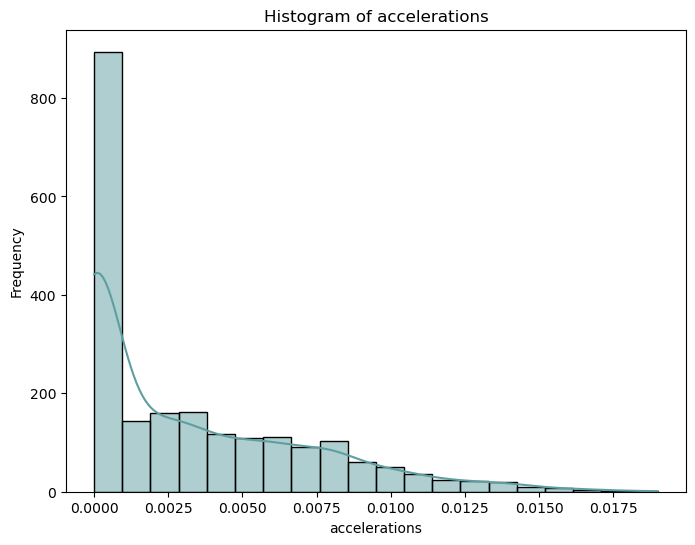

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
# 显示数据分布的直方图，直方图展示了数据在不同区间的分布情况，帮助我们了解数据的分布形态。
def plot_histogram(data, column):
    plt.figure(figsize=(8, 6))
    sns.histplot(data.toPandas()[column], bins=20, kde=True, color="#5F9EA0")
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

# 绘制直方图示例
plot_histogram(data, "baseline value")
plot_histogram(data, "accelerations")


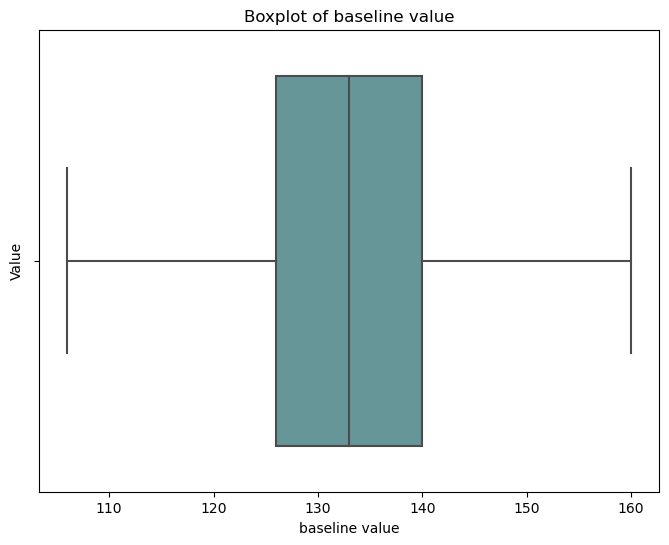

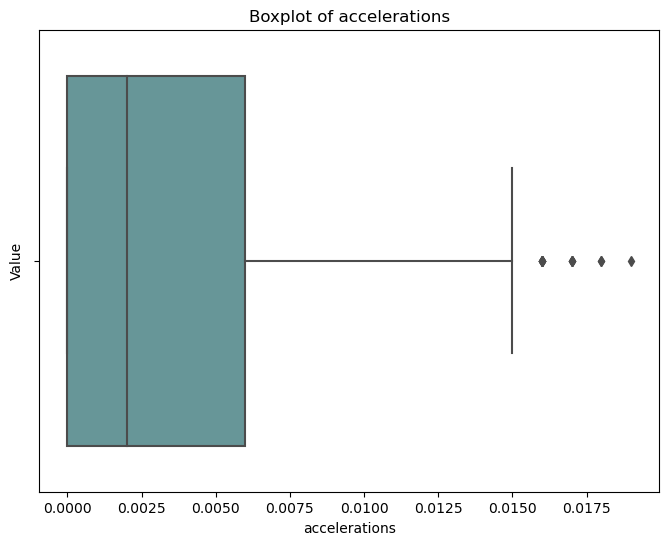

In [30]:

# 绘制箱线图示例，箱线图能够显示出数据的中位数、四分位数以及异常值，有助于我们了解数据的分布范围和离散程度。
def plot_boxplot(data, column):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data.toPandas(), x=column, color="#5F9EA0")
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.ylabel("Value")
    plt.show()

# 绘制箱线图示例
plot_boxplot(data, "baseline value")
plot_boxplot(data, "accelerations")

# Count the missing and null values
Here is good to count the missing and null values. In the case of a real-world dataset, it is very common that some values in the dataset are missing. We represent these missing values as NaN (Not a Number) values. But to build a good machine learning model our dataset should be complete. That’s why we use some imputation techniques to replace the NaN values with some probable values.

In [31]:
#输出数据的基本信息，包括每列的非空值数量和数据类型。
#DataFrame.info() method prints a concise summary of a DataFrame.This method prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.
data_pd.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [32]:
# Count the missing and null values for dataset fetal healt.计算了数据中每列的缺失值数量，并输出有缺失值的列的缺失值数量。
miss_values = data_pd.columns[data_pd.isnull().any()]
print(f"Missing values:\n{data_pd[miss_values].isnull().sum()}")

#计算了数据中每列的空值数量（NaN）并输出有空值的列的空值数量。
null_values = data_pd.columns[data_pd.isna().any()]
print(f"Null values:\n{data_pd[null_values].isna().sum()}")

Missing values:
Series([], dtype: float64)
Null values:
Series([], dtype: float64)


As the above result, In this case, there is neither null values nor missing values in the dataset.

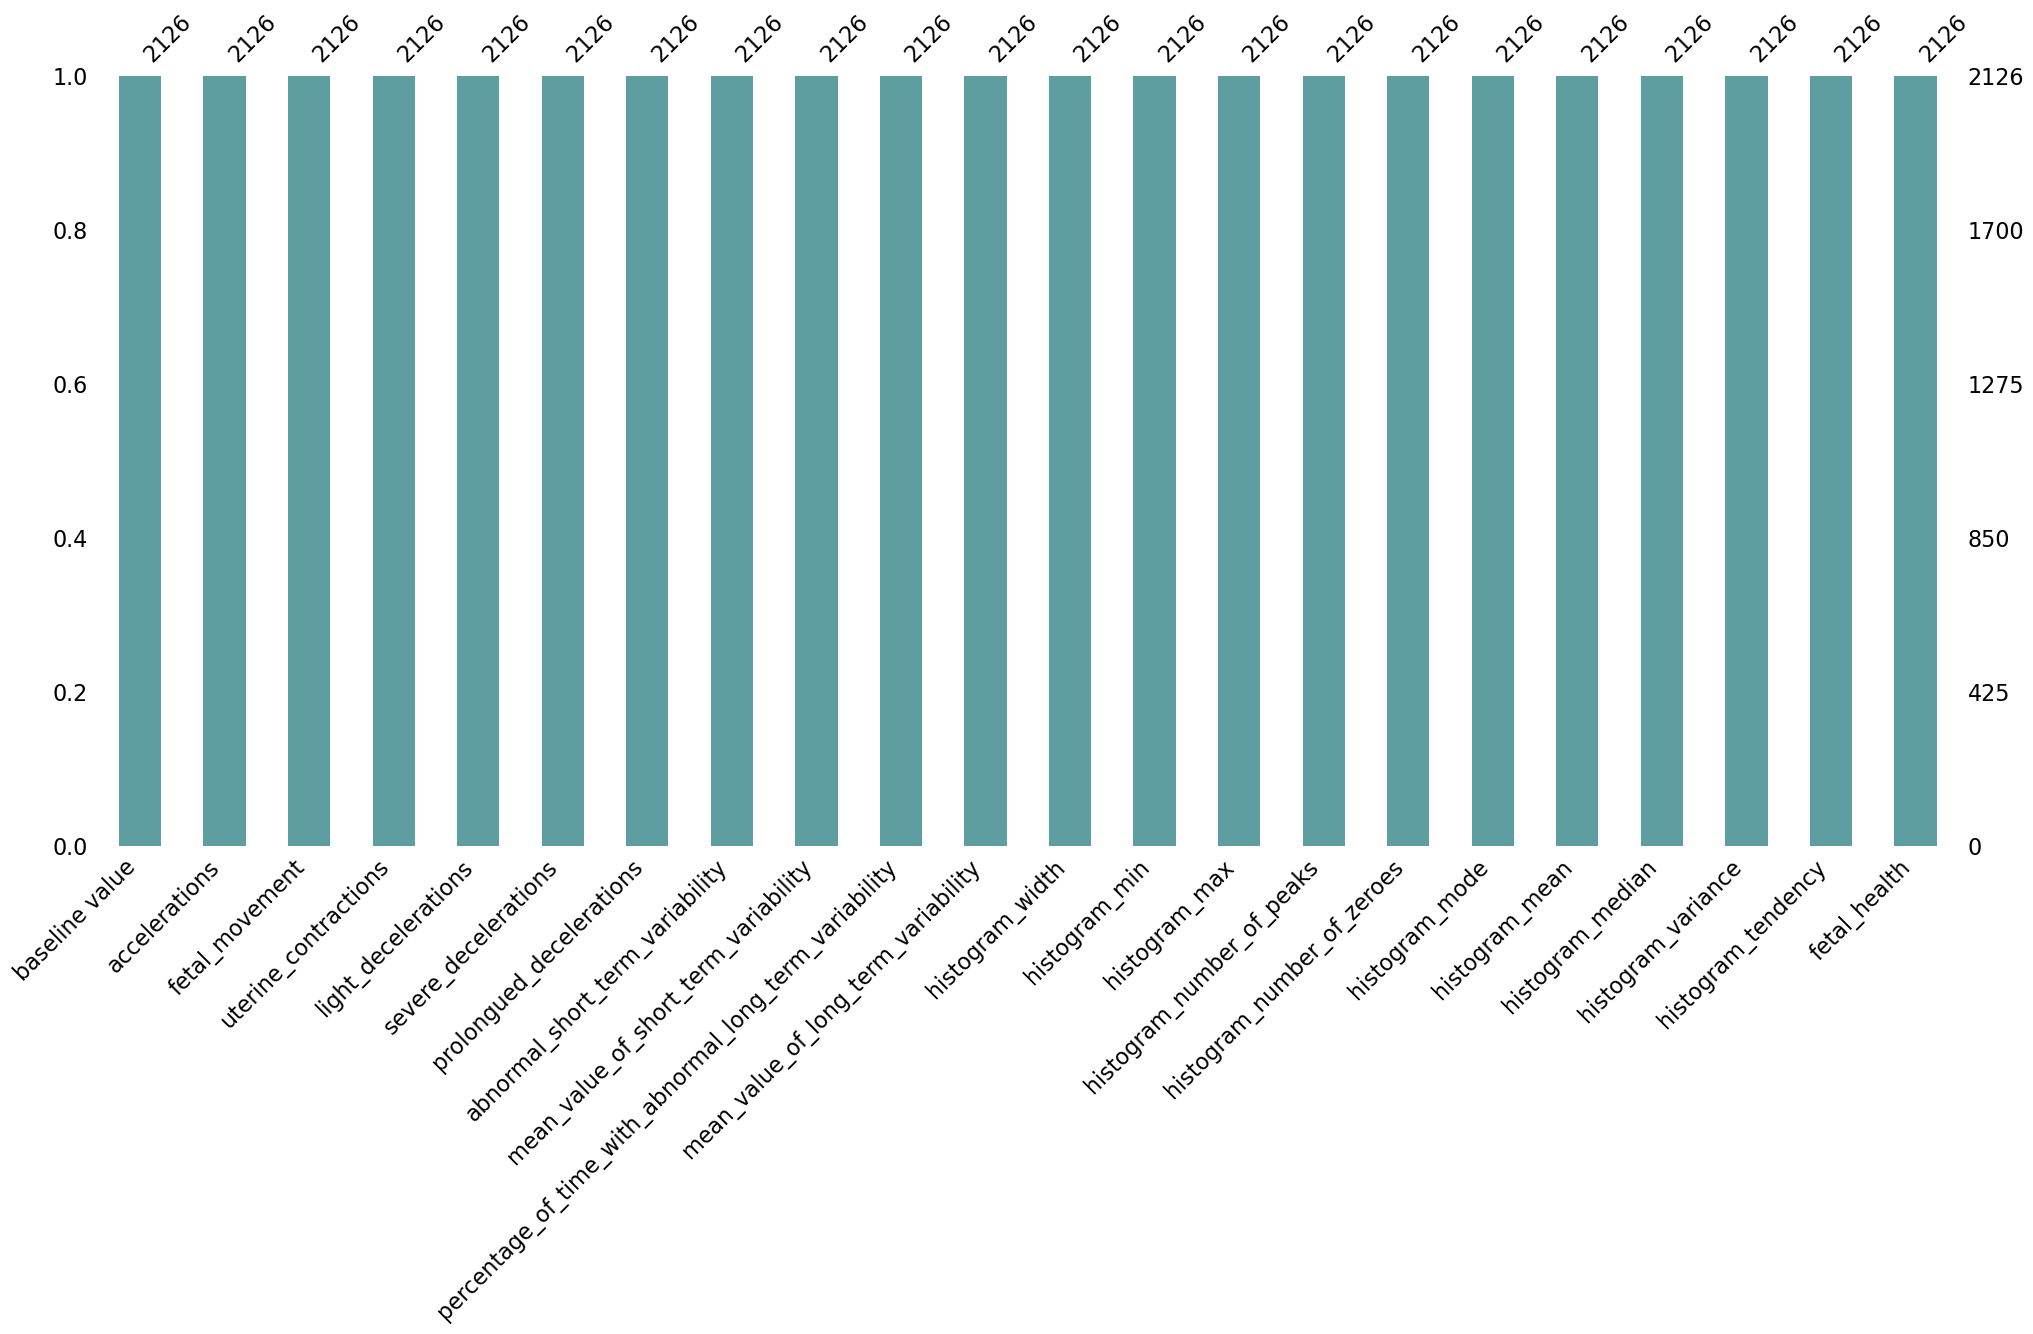

In [33]:
#Visualize missing values (NaN) using Missingno Library:
#使用 missingno 库绘制了一个条形图，展示了每列缺失值的情况。条形图的长度表示缺失值的百分比。
#Bar Chart :
#This bar chart gives us an idea about how many missing values are there in each column.


import missingno as msno
# Null count analysis
null_plot = msno.bar(data_pd, color = "#5F9EA0")

t-statistic: [624.57068853]
p-value: [0.]


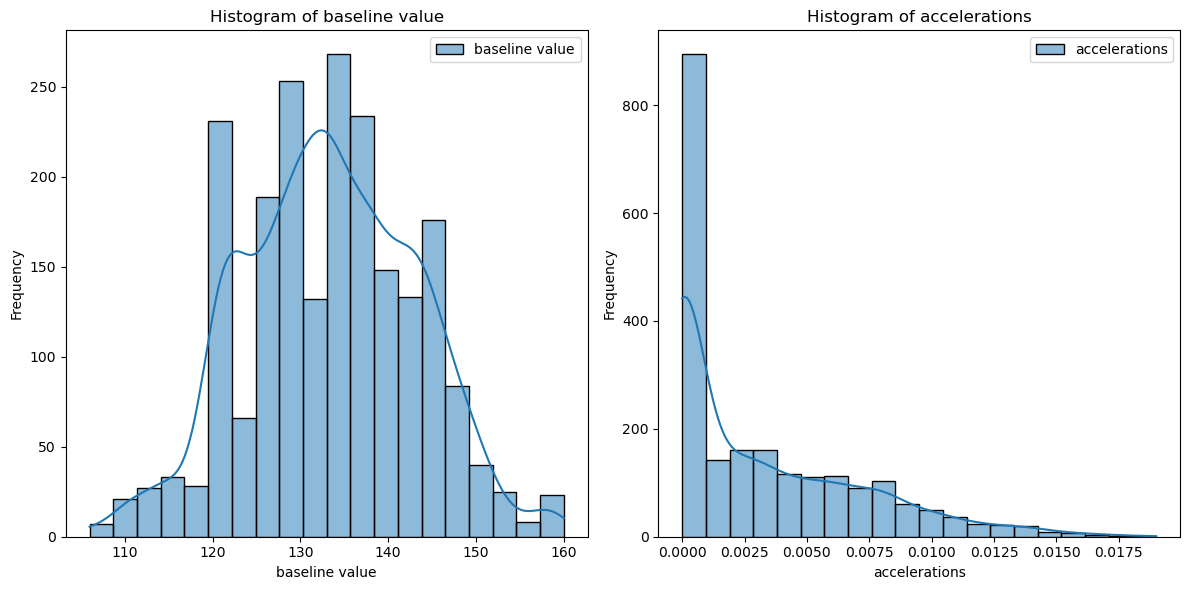

In [34]:
# 假设检验示例：t检验（示例使用Scipy库） hypothesis testing
feature1 = "baseline value"
feature2 = "accelerations"

# 获取两个特征的值，并转换为Pandas DataFrame
values_feature1 = data.select(col(feature1)).toPandas()
values_feature2 = data.select(col(feature2)).toPandas()

# 执行t检验
t_statistic, p_value = stats.ttest_ind(values_feature1, values_feature2)
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# 绘制两个特征的直方图
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(values_feature1, bins=20, kde=True, color="#5F9EA0")
plt.title(f"Histogram of {feature1}")
plt.xlabel(feature1)
plt.ylabel("Frequency")

plt.subplot(122)
sns.histplot(values_feature2, bins=20, kde=True, color="#B0E0E6")
plt.title(f"Histogram of {feature2}")
plt.xlabel(feature2)
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

below:
    # Scaling the data
    
    Feature scaling in machine learning is one of the most critical steps during the pre-processing of data before creating a machine learning model. Scaling can make a difference between a weak machine learning model and a better one. The most common techniques of feature scaling are Normalization and Standardization. Normalization is used when we want to bound our values between two numbers, typically, between [0,1] or [-1,1]. While Standardization transforms the data to have zero mean and a variance of 1, they make our data unitless.

标准化（StandardScaler）可以在某些情况下提升模型训练的效果，但并不是在所有情况下都一定会有显著的提升。它的作用是将特征数据进行线性变换，使得每个特征的均值为0，标准差为1。这有助于解决特征之间尺度不同的问题，以及一些优化算法对特征尺度敏感的情况。

标准化的好处包括：

去除尺度差异：在某些机器学习算法中，特征的尺度差异会导致模型难以收敛，标准化可以缓解这个问题，提高模型的稳定性和效果。

优化优化算法：一些优化算法（如梯度下降）可能对特征尺度敏感，标准化可以帮助这些算法更快地收敛。

提升模型性能：对于一些模型（如支持向量机、K近邻等），标准化可以提升模型的性能。

然而，标准化并不是所有情况下都适用的。例如：

树模型：决策树、随机森林等树模型不一定对特征尺度敏感，因为它们对特征的分裂并不依赖于特征的绝对值。

稀疏数据：对于稀疏数据，标准化可能会破坏特征的原始含义。

特征本身尺度不重要：如果特征的尺度差异不会影响模型的性能，那么标准化可能不会有太大影响。

最终是否使用标准化取决于具体的情况，通常建议先尝试标准化，然后比较标准化后和未标准化的模型性能，看是否有明显的提升。在某些情况下，标准化可能对模型的性能产生积极影响，但并不是绝对的。

In [35]:
#使用 sklearn 库中的 StandardScaler 对特征进行了标准化处理，以确保特征之间的尺度差异不会影响机器学习模型的性能。特征列通过 scale_X.fit_transform() 方法进行标准化，并存储在 DataFrame X 中。这将有助于在训练分类模型时获得更好的结果。

from pyspark.sql import Row
from pyspark.sql.functions import col
from sklearn.preprocessing import StandardScaler
# 特征列
feature_columns = ['baseline value', 'accelerations', 'fetal_movement',
                   'uterine_contractions', 'light_decelerations', 'severe_decelerations',
                   'prolongued_decelerations', 'abnormal_short_term_variability',
                   'mean_value_of_short_term_variability',
                   'percentage_of_time_with_abnormal_long_term_variability',
                   'mean_value_of_long_term_variability', 'histogram_width',
                   'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
                   'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
                   'histogram_median', 'histogram_variance', 'histogram_tendency']

# 使用 sklearn 进行标准化处理
scale_X = StandardScaler()
X_scaled = scale_X.fit_transform(data_pd[feature_columns])
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

# 将标准化后的特征与原始的目标列合并
merged_data_pd = pd.concat([X_scaled_df, data_pd["fetal_health"]], axis=1)
data = spark.createDataFrame(merged_data_pd)


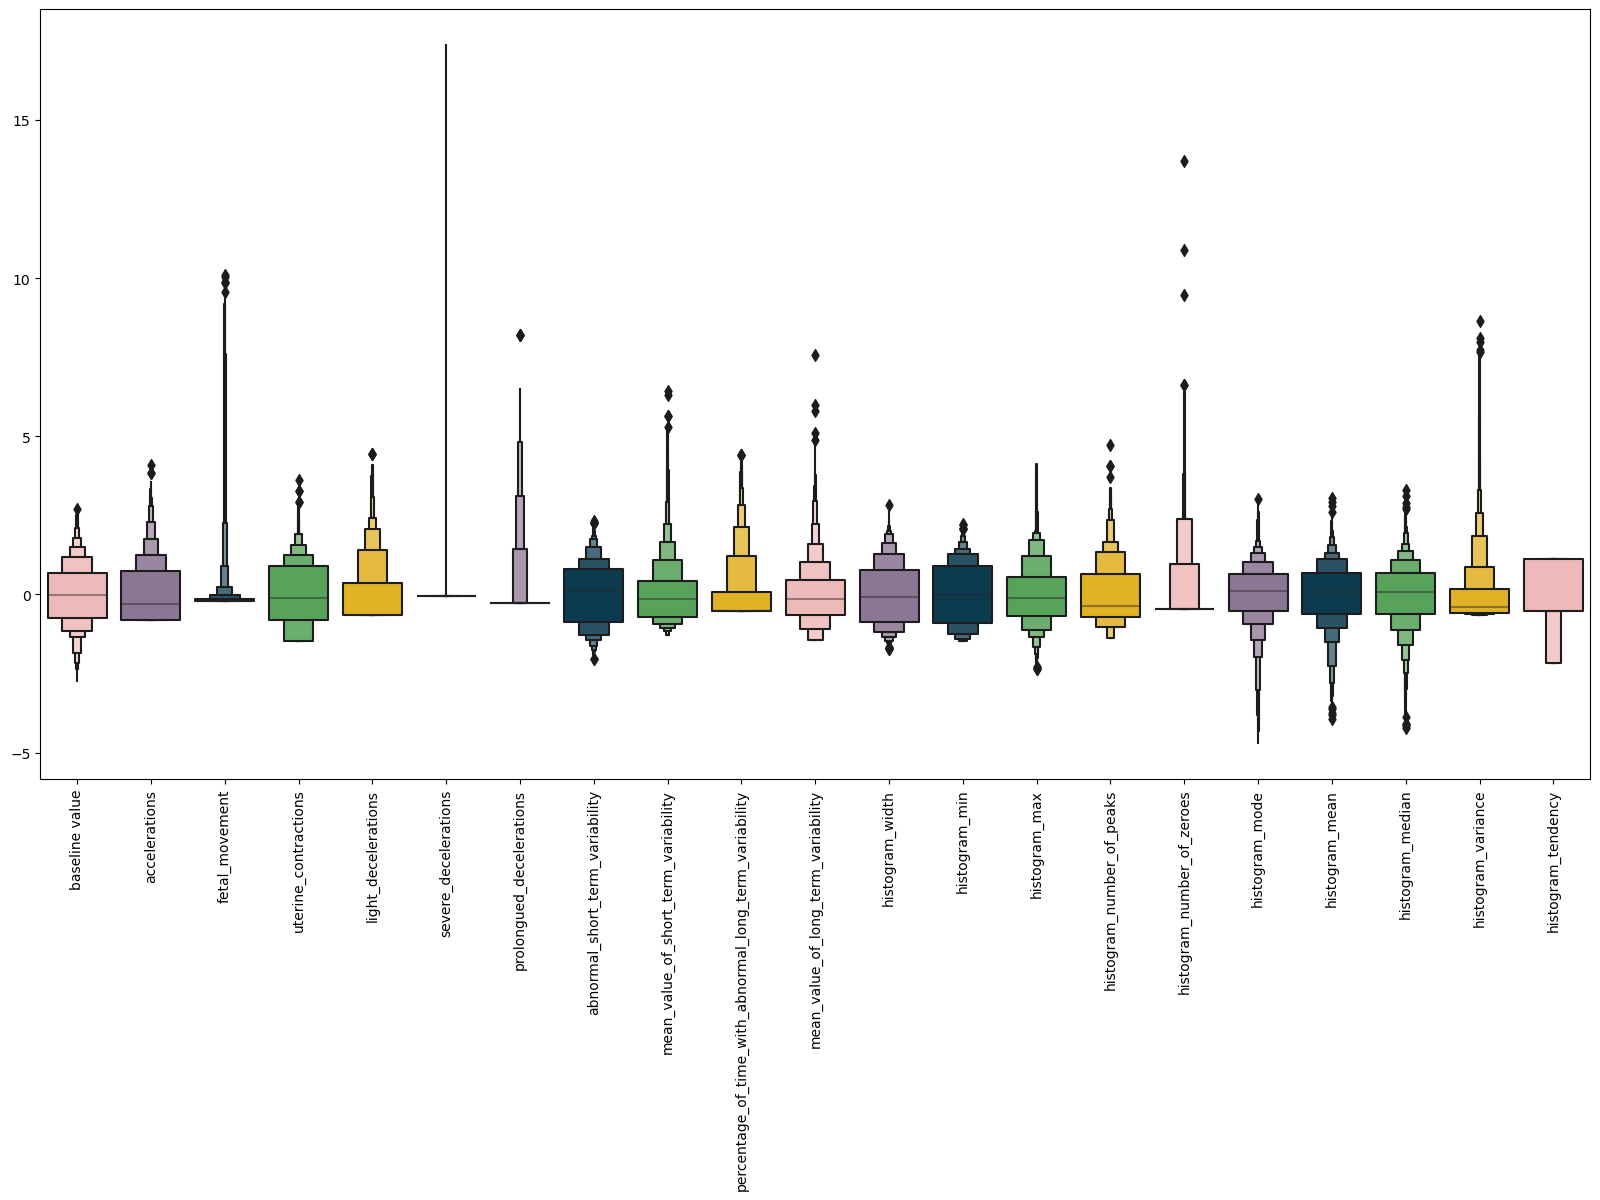

In [36]:
#looking at the scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_scaled_df,palette = shades)
plt.xticks(rotation=90)
plt.show()

对原始数据进行了预处理，以便后续的模型训练。具体解释如下：

首先，通过检查列的数据类型，找出所有非整数类型的特征列。

然后，对于每个非整数特征列，使用StringIndexer将其转换为数值类型的索引列。StringIndexer将字符串值映射到唯一的整数索引，从而使得算法可以对其进行处理。

接下来，使用OneHotEncoder对每个数值索引列进行独热编码。独热编码将每个整数索引转换为一个二进制向量，其中只有一个位置为1，表示对应的类别。

创建一个VectorAssembler实例，将经过独热编码的特征列组合成一个名为“features”的向量特征列。这是为了将所有特征整合到一个向量中，以便输入机器学习模型。

最后，将所有上述的数据转换步骤组合成一个Pipeline，并使用原始数据进行拟合。拟合后的Pipeline将对原始数据应用上述的转换，得到处理后的数据。

最终，通过显示处理后的数据，你可以看到每个非整数特征列已经经过了StringIndexer、OneHotEncoder和VectorAssembler的处理，最终生成了一个包含特征向量的新列“features”。

总之，此代码段为数据预处理阶段，将原始数据转换为适合机器学习模型训练的格式。

In [37]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
# 找出非整数数据列
non_int_cols = [col_name for col_name, col_type in data.dtypes if col_type != "int"]

# 创建StringIndexer和OneHotEncoder实例
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in non_int_cols]
encoders = [OneHotEncoder(inputCols=[f"{col}_index"], outputCols=[f"{col}_encoded"]) for col in non_int_cols]

# 创建VectorAssembler实例，不包含目标变量
assembler_inputs = [f"{col}_encoded" for col in non_int_cols if col != "fetal_health"]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


# 创建Pipeline并执行数据整理
stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=stages)
data_transformed = pipeline.fit(data).transform(data)

# 显示处理后的数据
# data_transformed.show()
data_transformed.select("fetal_health").distinct().show()


+------------+
|fetal_health|
+------------+
|         1.0|
|         3.0|
|         2.0|
+------------+



In [38]:
data.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+--------------------+-------------------+-------------------+-------------------------+--------------------------+-------------------+--------------------+--------------------+--------------------+-------------------+------------+
|      baseline value|       accelerations|      fetal_movement|uterine_contractions|light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|     histogram_width|      histogram_min|      histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|     histogram_mode|      histogr

1、分割数据集为训练集和测试集，确保训练和评估的数据集不重叠。

2、设计了四种不同的分类器：逻辑回归、决策树、随机森林和朴素贝叶斯。

3、使用MulticlassClassificationEvaluator创建了一个用于多分类问题评估的评估器，度量指标为准确率（accuracy）。

4、对于每个分类器，训练模型并在测试集上进行预测，然后使用评估器计算预测的准确率。最后，将分类器的名称和准确率打印出来。

5、对每个分类器的预测结果进行可视化。通过创建直方图，展示了每个预测类别的分布情况，从而更好地理解分类器的性能。

+------------+
|fetal_health|
+------------+
|         1.0|
|         3.0|
|         2.0|
+------------+



23/08/25 21:46:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/25 21:46:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Classifier: LogisticRegression
Accuracy: 0.9097560975609756


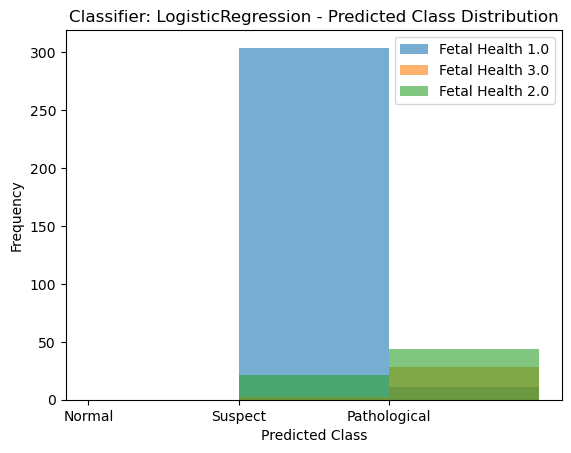

+------------+
|fetal_health|
+------------+
|         1.0|
|         3.0|
|         2.0|
+------------+



Classifier: DecisionTreeClassifier
Accuracy: 0.8682926829268293


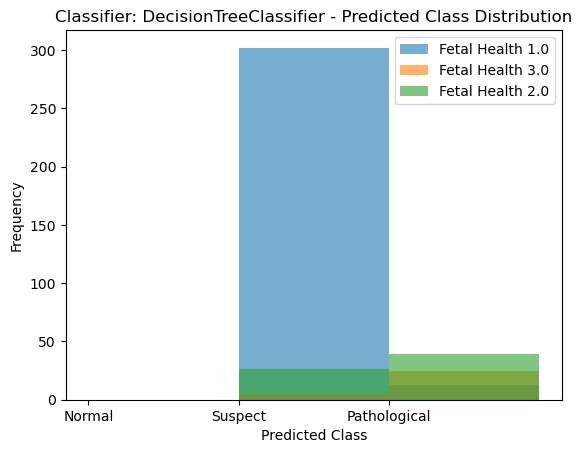

+------------+
|fetal_health|
+------------+
|         1.0|
|         3.0|
|         2.0|
+------------+

Classifier: RandomForestClassifier
Accuracy: 0.7682926829268293


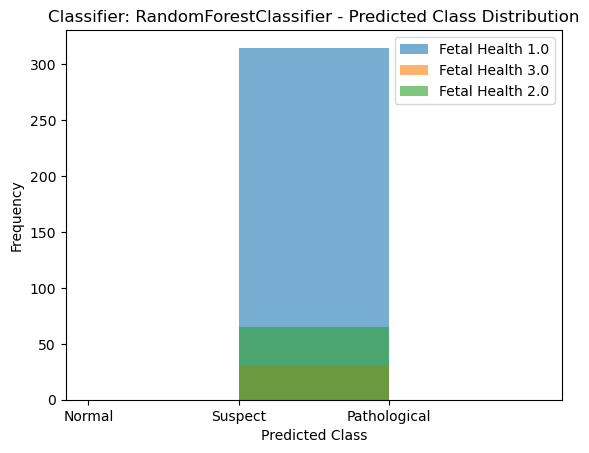

+------------+
|fetal_health|
+------------+
|         1.0|
|         3.0|
|         2.0|
+------------+

Classifier: NaiveBayes
Accuracy: 0.05365853658536585


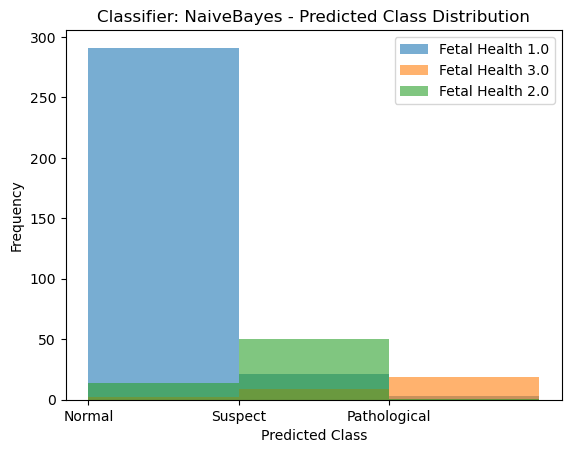

In [39]:
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier, GBTClassifier, OneVsRest


import matplotlib.pyplot as plt


# 分割数据集为训练集和测试集
# 将数据分成80%的训练集和20%的测试集，确保训练和评估的数据集不重叠
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=123)

# 设计多类别分类器
# 定义了四种不同的分类器：逻辑回归、决策树、随机森林和朴素贝叶斯
classifiers = [
    LogisticRegression(featuresCol="features", labelCol="fetal_health", maxIter=10, regParam=0.01, family="multinomial"),
    DecisionTreeClassifier(featuresCol="features", labelCol="fetal_health"),
    RandomForestClassifier(featuresCol="features", labelCol="fetal_health", numTrees=10),
    NaiveBayes(featuresCol="features", labelCol="fetal_health"),
]

# 对于多类别分类问题，使用MulticlassClassificationEvaluator进行评估
# 创建了一个用于多分类问题评估的评估器，度量指标为准确率（accuracy）
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="fetal_health", metricName="accuracy")

# 训练、评估和可视化每个分类器的性能
for classifier in classifiers:

    train_data.select("fetal_health").distinct().show()

    model = classifier.fit(train_data)
    predictions = model.transform(test_data)
    
    # 使用评估器计算预测的准确率
    accuracy = evaluator.evaluate(predictions)
    
    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Accuracy: {accuracy}")
    
    # 可视化分类器性能
    predictions_pd = predictions.select("prediction", "fetal_health").toPandas()
    plt.figure()
    for label in predictions_pd["fetal_health"].unique():
        subset = predictions_pd[predictions_pd["fetal_health"] == label]
        plt.hist(subset["prediction"], bins=range(4), alpha=0.6, label=f"Fetal Health {label}")
    plt.legend(loc="upper right")
    plt.title(f"Classifier: {classifier.__class__.__name__} - Predicted Class Distribution")
    plt.xlabel("Predicted Class")
    plt.ylabel("Frequency")
    plt.xticks(range(3), ["Normal", "Suspect", "Pathological"])
    plt.show()


1、创建了一个随机森林分类器，作为训练模型的基础分类器。

2、定义了一个参数网格，其中包含不同的numTrees（树的数量）和maxDepth（树的最大深度）参数组合，用于交叉验证来寻找最佳参数组合。
> 2.1 numTrees 参数设置：numTrees 是随机森林中树的数量。选择合适的树的数量是一个重要的超参数，过多的树可能导致过拟合，而过少的树可能导致欠拟合。在这段代码中，选择了 [10, 20, 30] 这几个值作为备选，这是一个常见的范围，用于尝试不同数量的树，以找到在验证集上性能最佳的数量。

> 2.2 maxDepth 参数设置：maxDepth 是每棵树的最大深度，即树的最大层数。较大的深度可以允许模型更多地学习数据的细节，但也容易过拟合。较小的深度可以减少过拟合的风险，但可能损失一些复杂模式的学习。在这段代码中，选择了 [5, 10, 15] 这几个值作为备选，以在不同的深度下评估模型的性能。

3、创建了一个交叉验证实例（CrossValidator），它使用不同的参数组合对随机森林模型进行评估，评估器为之前定义的多分类评估器。
> 3.1 numFolds=3 表示交叉验证（Cross-Validation）的折数。在机器学习中，交叉验证是一种常用的模型评估技术，旨在更好地估计模型在未见过数据上的性能。交叉验证将数据集分成多个子集（也称为“折”），然后多次训练和验证模型，确保每个子集都在验证集中出现一次。参数numFolds 指定了交叉验证中的折数。

在这个代码段中，numFolds=3 意味着将数据集分成三个子集，然后执行三次交叉验证实验。每次实验中，两个子集被用作训练集，另一个子集被用作验证集。这种方法的一个优点是，它可以更稳定地估计模型的性能，因为每个子集都会被用作验证集。

4、在训练数据上运行交叉验证，选择最佳参数组合并训练最佳模型。

5、使用最佳模型在测试数据上进行预测，然后使用评估器计算预测的准确率作为性能评估指标。

6、打印出最佳模型的准确率，以评估模型在测试集上的性能

In [41]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 创建分类器（以随机森林为例）
classifier = RandomForestClassifier(featuresCol="features", labelCol="fetal_health", numTrees=10)

# 创建参数网格
param_grid = ParamGridBuilder() \
    .addGrid(classifier.numTrees, [10, 20, 30]) \
    .addGrid(classifier.maxDepth, [5, 10, 15]) \
    .build()

# 创建交叉验证评估器
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="fetal_health", metricName="accuracy")

# 创建CrossValidator实例
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)  # 设置交叉验证的折数

# 运行交叉验证
cv_model = crossval.fit(train_data)

# 在测试集上评估交叉验证得到的模型
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)

print(f"Cross-validated Model Accuracy: {cv_accuracy}")


23/08/25 21:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB
23/08/25 21:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1013.7 KiB
23/08/25 21:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1075.2 KiB
23/08/25 21:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1135.7 KiB
23/08/25 21:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
23/08/25 21:47:43 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
23/08/25 21:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1022.9 KiB
23/08/25 21:47:50 WARN DAGScheduler: Broadcasting large task binary with size 1084.8 KiB
23/08/25 21:47:50 WARN DAGScheduler: Broadcasting large task binary with size 1151.6 KiB
23/08/25 21:47:50 WARN DAGScheduler: Broadcasting large task binary with size 1218.2 KiB
23/08/25 21:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1050.9 KiB
23/08/25 21:48:08 WAR

Cross-validated Model Accuracy: 0.8292682926829268


下述代码段旨在使用交叉验证来选择最佳的Logistic Regression模型参数（正则化参数和弹性网参数）。代码首先定义了一个LogisticRegression分类器，然后创建了一个参数网格，其中包含了不同的正则化参数和弹性网参数的组合。接着，代码创建了一个交叉验证实例（CrossValidator），通过在训练数据上进行多次训练和验证来寻找最佳参数组合。最后，代码在测试数据上评估了交叉验证得到的模型，并打印出模型的交叉验证准确率。

> regParam（正则化参数）：这个参数控制着正则化项的强度，帮助防止模型过拟合。较小的正则化参数允许模型拟合更多训练数据，但可能导致过拟合；较大的正则化参数会限制模型的复杂性，有助于泛化到新数据。在这里，选择了几个不同的正则化参数值（0.01、0.1、1.0），覆盖了不同的正则化强度，以找到一个在正则化和性能之间的平衡点。

> elasticNetParam（弹性网参数）：这是用于控制L1正则化（Lasso）和L2正则化（Ridge）之间权衡的参数。当弹性网参数为0时，模型将变为L2正则化（Ridge），为1时将变为L1正则化（Lasso）。中间值则结合了两者。在这里，选择了几个不同的弹性网参数值（0.0、0.5、1.0），以测试在L1和L2正则化之间的平衡。

变量数值设置的依据：

> numFolds=5：这里选择了5折交叉验证，即将数据集分成5个部分，每次实验中使用4个部分作为训练集，1个部分作为验证集。选择折数的目的是在可用的数据上进行多次验证，以更稳定地估计模型的性能。

正则化参数和弹性网参数：通过尝试不同的正则化参数和弹性网参数组合，可以找到在给定数据集上性能最佳的模型配置。这些参数的选择通常基于领域知识、经验和实验。正则化参数控制着模型的正则化程度，从而避免过拟合。弹性网参数结合了L1和L2正则化，可以有效地处理特征选择和共线性。

In [42]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 创建LogisticRegression分类器
classifier = LogisticRegression(featuresCol="features", labelCol="fetal_health", maxIter=10)

# 创建参数网格
param_grid = ParamGridBuilder() \
    .addGrid(classifier.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(classifier.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# 创建交叉验证评估器
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="fetal_health", metricName="accuracy")

# 创建CrossValidator实例
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)  # 设置交叉验证的折数

# 运行交叉验证
cv_model = crossval.fit(train_data)

# 在测试集上评估交叉验证得到的模型
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)

print(f"Cross-validated Model Accuracy: {cv_accuracy}")


Cross-validated Model Accuracy: 0.8975609756097561


首先，代码创建了三个评估器，分别用于计算加权召回率、加权精确率和F1分数，这些指标将帮助我们评估模型的分类性能。

然后，代码分别使用这些评估器对经过交叉验证的模型在测试集上的预测结果进行评估，计算出召回率、精确率和F1分数。

接着，代码输出了各项指标的结果，包括模型准确度、加权召回率、加权精确率和F1分数。

最后，代码通过使用Seaborn绘制了一个条形图，以可视化展示各项指标的结果。在图表中，x轴表示各项指标的值，y轴表示指标名称，每个条形表示一个指标，条形的高度表示指标的数值大小。条形图的颜色使用了"viridis"调色板。

Cross-validated Model Accuracy: 0.8975609756097561
Weighted Recall: 0.8975609756097561
Weighted Precision: 0.8932236606823547
F1 Score: 0.8897066772875869


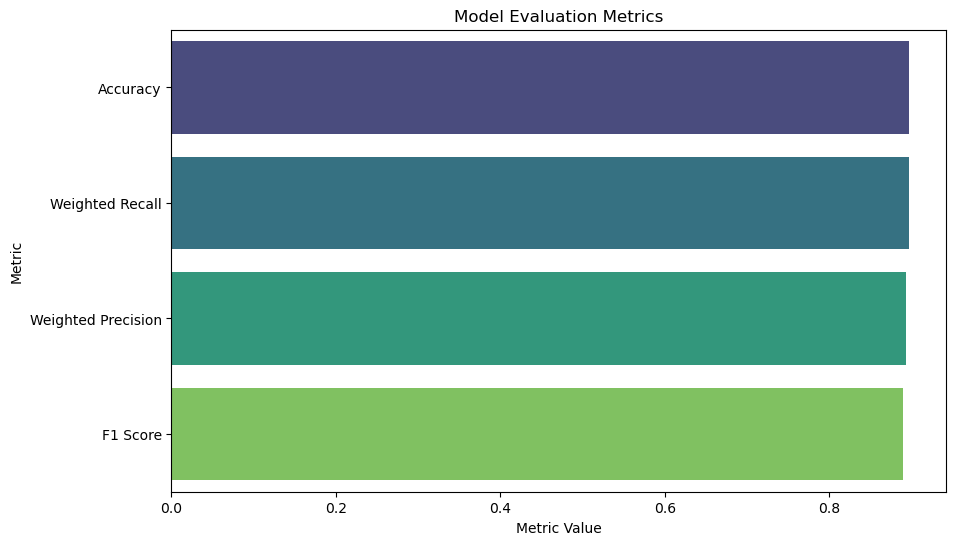

In [43]:
# 计算召回率、精确率和F1分数
recall_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedRecall")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedPrecision")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="f1")

recall = recall_evaluator.evaluate(cv_predictions)
precision = precision_evaluator.evaluate(cv_predictions)
f1_score = f1_evaluator.evaluate(cv_predictions)

# 输出各指标结果
print(f"Cross-validated Model Accuracy: {cv_accuracy}")
print(f"Weighted Recall: {recall}")
print(f"Weighted Precision: {precision}")
print(f"F1 Score: {f1_score}")

# 绘制指标的可视化图表
metrics = ["Accuracy", "Weighted Recall", "Weighted Precision", "F1 Score"]
values = [cv_accuracy, recall, precision, f1_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=metrics, palette="viridis")
plt.title("Model Evaluation Metrics")
plt.xlabel("Metric Value")
plt.ylabel("Metric")
plt.show()

Classifier: LogisticRegression
Cross-validated Model Accuracy: 0.9097560975609756


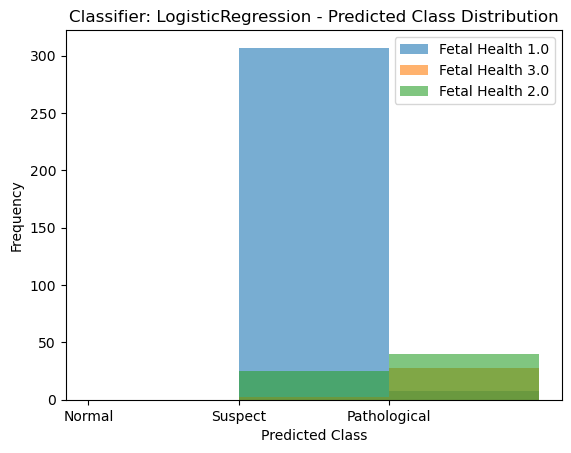

Classifier: DecisionTreeClassifier
Cross-validated Model Accuracy: 0.8682926829268293


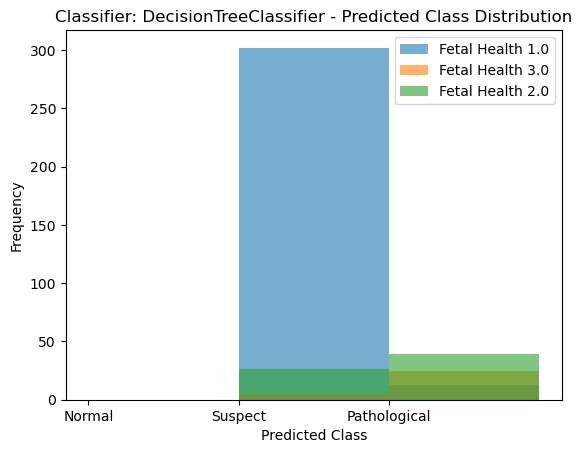

Classifier: RandomForestClassifier
Cross-validated Model Accuracy: 0.7682926829268293


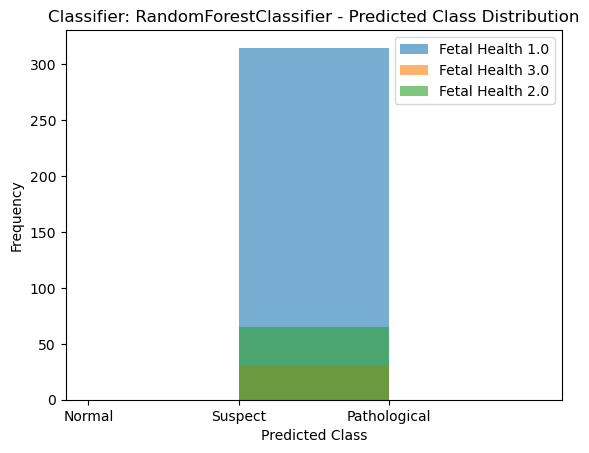

Classifier: NaiveBayes
Cross-validated Model Accuracy: 0.05365853658536585


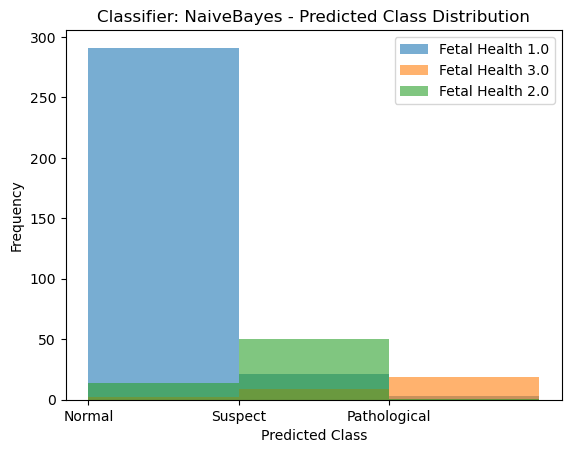

In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# 分割数据集为训练集和测试集
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=123)

# 设计多类别分类器
classifiers = [
    LogisticRegression(featuresCol="features", labelCol="fetal_health", regParam=0.01, family="multinomial"),
    DecisionTreeClassifier(featuresCol="features", labelCol="fetal_health"),
    RandomForestClassifier(featuresCol="features", labelCol="fetal_health"),
    NaiveBayes(featuresCol="features", labelCol="fetal_health"),
]

# 定义参数网格
paramGrid = ParamGridBuilder() \
    .addGrid(LogisticRegression.maxIter, [10, 20]) \
    .addGrid(DecisionTreeClassifier.maxDepth, [5, 10]) \
    .addGrid(RandomForestClassifier.numTrees, [10, 20]) \
    .addGrid(NaiveBayes.smoothing, [0.5, 1.0]) \
    .build()

# 使用交叉验证进行网格搜索
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="fetal_health", metricName="accuracy")
crossval = CrossValidator(estimator=classifiers[0], estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# 训练、评估每个分类器的性能
for classifier in classifiers:
    crossval.setEstimator(classifier)
    cvModel = crossval.fit(train_data)
    predictions = cvModel.transform(test_data)
    
    accuracy = evaluator.evaluate(predictions)
    
    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Cross-validated Model Accuracy: {accuracy}")
    
   # 可视化分类器性能
    predictions_pd = predictions.select("prediction", "fetal_health").toPandas()
    plt.figure()
    for label in predictions_pd["fetal_health"].unique():
        subset = predictions_pd[predictions_pd["fetal_health"] == label]
        plt.hist(subset["prediction"], bins=range(4), alpha=0.6, label=f"Fetal Health {label}")
    plt.legend(loc="upper right")
    plt.title(f"Classifier: {classifier.__class__.__name__} - Predicted Class Distribution")
    plt.xlabel("Predicted Class")
    plt.ylabel("Frequency")
    plt.xticks(range(3), ["Normal", "Suspect", "Pathological"])
    plt.show()








CORR_THRESHOLD = 0.1：定义了一个相关性阈值，它表示了与胎儿健康指标的相关性必须超过或低于该阈值才会被选择。

corr_with_target = data_pd.corr()["fetal_health"].reset_index()：计算数据中每个特征与胎儿健康指标的相关性，并将结果存储在一个 DataFrame 中。data_pd 是一个 Pandas DataFrame，corr() 方法用于计算特征之间的相关性矩阵。

corr_with_target = corr_with_target.loc[(corr_with_target["index"] != "fetal_health") & ((corr_with_target["fetal_health"] > CORR_THRESHOLD) | (corr_with_target["fetal_health"] < -CORR_THRESHOLD))]：在计算得到的相关性 DataFrame 中，首先排除了与胎儿健康指标本身相关的条目。然后，根据阈值筛选出与胎儿健康指标的相关性超过阈值或低于负阈值的条目。

features = corr_with_target['index'].tolist()：将符合条件的特征的名称提取为一个列表，并存储在 features 变量中。这些特征与胎儿健康指标的相关性符合阈值要求。

这段代码的目的是根据与胎儿健康指标的相关性来选择具有一定相关性的特征，以便在进一步的分析、建模或预测中使用。

In [45]:
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
# Select the features that have a correlation with fetal health above a threshold
CORR_THRESHOLD = 0.1
corr_with_target = data_pd.corr()["fetal_health"].reset_index()
corr_with_target = corr_with_target.loc[(corr_with_target["index"] != "fetal_health")
                                        & ((corr_with_target["fetal_health"] > CORR_THRESHOLD)
                                           | (corr_with_target["fetal_health"] < -CORR_THRESHOLD))]
features = corr_with_target['index'].tolist()

# Split the dataset into training and testing sets
X = data_pd[features]
y = data_pd['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
# Define a dictionary with some classifiers to be evaluated
algorithms = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'GaussianNB': GaussianNB(),
    'SVC (linear)': SVC(kernel='linear'),
    'SVC (rbf)': SVC(kernel='rbf'),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
    'LGBMClassifier': LGBMClassifier(),
}

# Evaluate each classifier using cross-validation and compute the average accuracy
models = pd.DataFrame(columns=['Model Name', 'Accuracy'])
for name, model in tqdm(algorithms.items()):
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    avg_accuracy = (np.mean(accuracies) * 100).round(2)
    models = models.append({'Model Name': name, 'Accuracy': avg_accuracy}, ignore_index=True)

# Sort the models by accuracy in descending order and select the best one
models = models.sort_values(by="Accuracy", ascending=False)
best_model_name = models.iloc[0]['Model Name']
best_model_accuracy = models.iloc[0]['Accuracy']
print(models)
print(f"\nThe best model is {best_model_name} with an accuracy of {best_model_accuracy}%")

100%|█████████████████████████████████████████████| 9/9 [00:07<00:00,  1.15it/s]

                   Model Name  Accuracy
3  GradientBoostingClassifier     94.88
8              LGBMClassifier     94.71
7      RandomForestClassifier     94.35
1      DecisionTreeClassifier     92.59
2        KNeighborsClassifier     89.82
5                SVC (linear)     88.00
0          LogisticRegression     87.24
6                   SVC (rbf)     85.82
4                  GaussianNB     84.35

The best model is GradientBoostingClassifier with an accuracy of 94.88%


In [47]:
# Train the best model on the whole dataset and evaluate it on the testing set
best_model = globals()[best_model_name]()
best_model.fit(X, y)
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final model accuracy: {final_accuracy}")

Final model accuracy: 0.9859154929577465


In [48]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

acccuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
f1_score = f1_score(y_test, y_pred, average="micro")

print("********* LGBMClassifier Results *********")
print("Accuracy    : ", acccuracy)
print("Recall      : ", recall)
print("Precision   : ", precision)
print("F1 Score    : ", f1_score)

********* LGBMClassifier Results *********
Accuracy    :  0.9859154929577465
Recall      :  0.9859154929577465
Precision   :  0.9858639304143645
F1 Score    :  0.9859154929577465


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       315
         2.0       0.97      0.94      0.96        69
         3.0       1.00      0.98      0.99        42

    accuracy                           0.99       426
   macro avg       0.99      0.97      0.98       426
weighted avg       0.99      0.99      0.99       426



<Axes: >

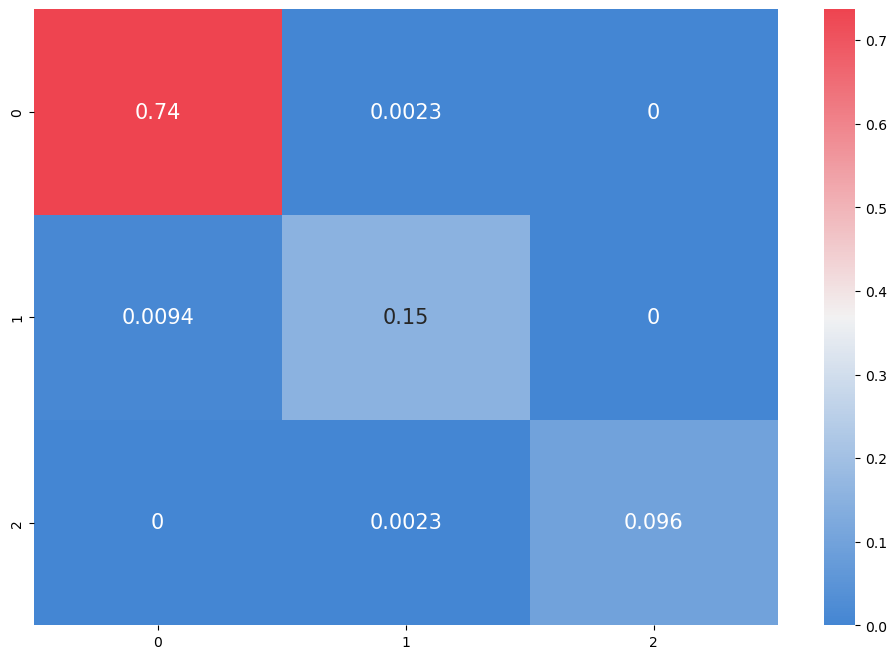

In [50]:
# cofusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap=cmap,annot = True, annot_kws = {'size':15})